# Deep Learning and Neural Networks Second Assignment 2023

## Ferenc Huszár and Nic Lane

### due date: Friday, 17 February 2023, 12:00 PM

Welcome to the second assignment for the Deep Neural Networks module. In this assignment you will explore some of the model architectures we talked about in the second half of lectures, focussing on ConvNets vor vision and small Transformers for text.

There are 70 marks given in total for this second assessment ($70\%$ of the total of 100 marks for the course), broken into three sections:
* (C) 15 marks for the guided tasks on ConvNets
* (D) 15 marks for the guided tasks on Transformers
* (E) 40 marks for a mini-project of your choice

#### Mini-projects


Mini-project tasks are a more exploratory and open-ended, giving you an opportunity to decide which aspect you'd like to focus on. The idea is to introduce you to the form of assessment typical in our Part III/MPhil modules. Mini-projects come with instructions, to indicate the depth of work we expect for certain marks, but you should feel free to deviate from instructions if you have a better idea to explore within the context.

As a guide, when marking we will take into account three factors:

* **extent of work:** did you do the expected amount of work (you won't get extra marks by doing a lot more than others, this is not a race). We will try to give an indication of this in the module description.
* **correctness/technical quality:** is your solution and description of findings technincally correct, does it demonstrate learning and understanding of the topics we cover?
* **presentation:** How is the mini-project written up? You want the writeup to be short, to the point, well structured. Are figures well formatted, so it's clear what's shown on them (e.g. are there axis labels)?

You can choose whichever project you want to attempt. You can attempt more than one, but we will only mark one. **Please clearly state which of the mini-projects you would like us to mark**, if this is unclear, we will mark whichever appears fist in your submitted notebook.

# C: Convolutional Networks

In these questions we will work with convolutional networks, and in particular residual networks (ResNets) which are networks with skip connections. In order to save time, we won't be training these models ourselves. Pytorch provides pre-*trained* weights for a range of commonly used models in the `torchvision` package, including ResNets of various depth. Most of the pretrained ResNets available are slightly improved versions of those proposed in 'Deep Residual Learning for Image Recognition' by [He et al (2015)](https://arxiv.org/pdf/1512.03385.pdf).

Note: you can request colab to run on a GPU by going to Runtime -> Change runtime type. However, since we are only going to work with single images, this may not buy you significant speedup.

## Setting up: Blas the border collie

To start, we will look at whether ResNets of different length can correctly classify my friend's dog Blas as a Border Collie.

In [ ]:
!wget https: // caballerojose.com / images / blas.jpg -P blas_the_dog / test

--2023-03-10 20:41:28--  https://caballerojose.com/images/blas.jpg
Resolving caballerojose.com (caballerojose.com)... 185.199.109.153, 185.199.108.153, 185.199.110.153, ...
Connecting to caballerojose.com (caballerojose.com)|185.199.109.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 221678 (216K) [image/jpeg]
Saving to: ‘blas_the_dog/test/blas.jpg’

blas.jpg            100%[===================>] 216.48K  --.-KB/s    in 0.03s   

2023-03-10 20:41:28 (6.87 MB/s) - ‘blas_the_dog/test/blas.jpg’ saved [221678/221678]



### Loading an image

We will use the Python Imaging Library (PIL) to load the image. Colab then displays the image in-line if it is the output of the last line in the cell. Hello Blas!

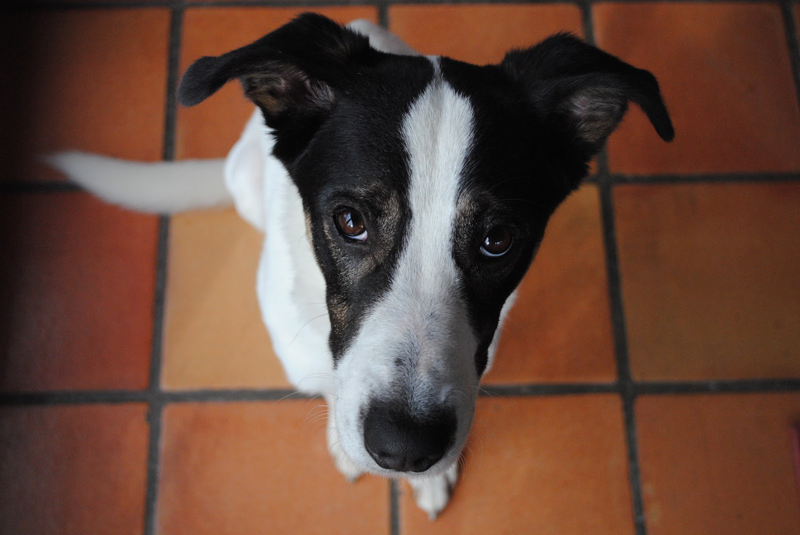

In [ ]:
from PIL import Image

img = Image.open('blas_the_dog/test/blas.jpg')
img.resize((800, 535))

### Transformations

ConvNets expect input images to be of a certain size, otherwise the dimensions of the tensors within the network don't work out. We have to resize this image so it is of size $224\times 224$ as the network expects. Secondly, when training neural networks, we often normalise the inputs (substract the mean and divide by the standard deviation). As this model was trained on ImageNet, we have to use the mean and standard deviation from this dataset. Thankfully, we don't have to compute this, as it's included in the [pytorch documentation](https://pytorch.org/vision/0.8/models.html) (as well as elsewhere on the internet).

We will use `transforms` from the `torchvision` module to apply these transformations to the image. We also convert from `PIL.Image` to `torch.Tensor` in the process:


In [ ]:
from torchvision import transforms

transform = transforms.Compose([transforms.Resize(255),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize(
                                    mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225]
                                )])

img_t = transform(img)

We can display the transformed image by converting it back to `PIL.Image`. We can see that the image was downsized, cropped to it's centre square region, and the colours are messed up due to normalization.

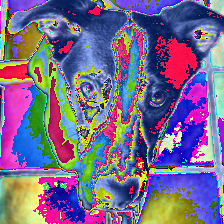

In [ ]:
transforms.ToPILImage()(img_t)

### Loading  the model

Now we are going to load the pre-trained 18-layer ResNet model from the `torchvision` library.

In [ ]:
from torchvision import models

resnet18 = models.resnet18(pretrained=True)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Let's see how the model classifies Blas, the border collie. For this, we have to turn the image tensor into a minibatch of 1 example, which practically means adding an extra dimension to the tensor. This can be done using the `unsqueeze` function.

In [ ]:
x = img_t.unsqueeze(0)
y = resnet18(x)
y.size()

torch.Size([1, 1000])

The model's output is a vector of 1000 logits, one for each class in the ImageNet dataset. To interpret this, we have to know what the ImageNet classes are. Also, the logits themselves are less human-readable, so we are going to turn them into probabilities using a `softmax` function. This helper function below will do this for us.

In [ ]:
import requests
import json
from torch.nn.functional import softmax

imagenet_labels_url = 'https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json'
response = requests.get(imagenet_labels_url)
imagenet_class_names = json.loads(response.text)


def top_5_classes(y, class_names=None):
    if class_names == None:
        imagenet_labels_url = 'https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json'
        response = requests.get(imagenet_labels_url)
        class_names = json.loads(response.text)
    p = softmax(y[0, :], dim=0)
    values, indices = p.topk(5)
    return [(class_names[index], value) for index, value in zip(indices.detach().numpy(), values.detach().numpy())]

In [ ]:
top_5_classes(y)

[('bucket', 0.007806162),
 ('plunger', 0.007172803),
 ('hook', 0.0070160483),
 ('waste container', 0.0054811286),
 ('water bottle', 0.0054325894)]

Oops, the model doesn't seem to recognise Blas. It thinks Blas is a bucket, plunger or hook. This is because in order to use the pretrained models in pytorch, we have to set them to evaluation mode. When training deep neural networks, sometimes the networks work differently at training and test time. For example, when using a technique called dropout, random units in the network may be dropped at training time, but at test time, all units are used and their output is scaled. Similarly, when using batch normalisation, the network works differently in training time and at test time. To set models to evaluation mode we can use the `eval` function.

In [ ]:
resnet18.eval()
y = resnet18(x)
top_5_classes(y)

[('Staffordshire Bull Terrier', 0.18194388),
 ('Cardigan Welsh Corgi', 0.14102182),
 ('American Staffordshire Terrier', 0.12816106),
 ('Basenji', 0.09343249),
 ('Whippet', 0.09127153)]

OK, getting there. At least the model now recognises Blas as a dog, but misses the specific breed. The correct class would be a Border Collie.

## Inspecting networks

For the next questions, you will need to look inside the pre-trained networks, and later, you will start modifying them. Below, we share a few things that will help you learn how models work. First, let's look at what the `resnet18` architecture looks like and how that architecture is represented in pytorch. You can print the model to see a text description of it:

In [ ]:
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Here, modules are listed from top to bottom in order of how they are executed.In a pytorch ResNet, residual blocks are organised into `layers`, each of which contain sequences of residual blocks. You will notice that:
* the number of channels keeps doubling at each layer, in this case from 128 -> 256 -> 512.
* at the same time, the figure size is halved with each layer. The image size is halved by `MaxPool2d` layers as well as strided convolutions where the stride is `2`.
* a `resnet18` is built out of `BasicBlock` building blocks, which are the simple residual block proposed by [He et al, (2015)](https://arxiv.org/abs/1512.03385) which I showed in the lecture. Deeper ResNets, such as `resnet50` use a more complicated `Bottleneck` component instead.
* in pytorch, the linear and nonlinear parts of a layer are separate, i.e. the convolution and subsequent ReLU activation are handled as separate layers.

To access the second convolution layer from the second residual block at the third layer, you can write the following:

In [ ]:
resnet18.layer3[1].conv2

Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

And you can access parameters of layers like so.

In [ ]:
resnet18.conv1.weight.size()

torch.Size([64, 3, 7, 7])

We can visualise the convolution kernels on the first layer using the code below. In addition to showing how to access weights, you may find some of this code useful as an example of using the `matplotlib.pylab` package for plotting.

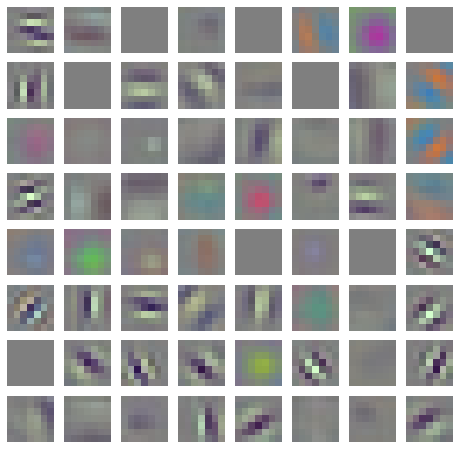

In [ ]:
import numpy as np
from matplotlib import pylab as plt

f = plt.figure(figsize=(8, 8))

weights = resnet18.conv1.weight.detach().numpy()
#normalising weights so a value of 0 becomes gray, and colours stay within [0,1]
weights = weights / (np.abs(weights).max()) / 2 + 0.5

#there are 64 convolution kernels, which we will arrange along an 8x8 grid
for i, w in enumerate(weights):
    plt.subplot(8, 8, i + 1)
    # we move the colour channel axis to the end, this is where imshow expects it
    plt.imshow(np.moveaxis(w, 0, -1));
    plt.axis('off')

In pytorch, you can inspect what each layer of the network does by using forward hooks. A forward hook is a python function that gets called whenever the layer is evaluated (i.e. data is passed through the layer). The forward hook function receives both the input and the output of the module. In pytorch, you can add a forward hook using the register_forward_hook function.

For example, in the code below, I attach a hook to a layer, which simply prints something out. Instead of attaching the hook to the resnet18, I first create a `deepcopy` of the model, so the hook gets attached to the copy, but not to the `resnet18` model which I may use later.

In [ ]:
import copy


def useless_hook(module, input, output):
    print('The hook was called.')


model = copy.deepcopy(resnet18)
model.layer3[1].conv2.register_forward_hook(useless_hook)
y = model(x)
y = model(x)

The hook was called.
The hook was called.


## Question C.1: Inspecting layers in neural networks

*3 marks*

This question has a subtasks:
1. print the number of parameters in each of the operations/layers of the `ResNet18`, and count how many there are in total.
1. print the *shape of the output tensor* of the second convolution operation (`conv2`) within every single residual block in a `ResNet18`. *Tip:* you can use a forward hook.
1. Extract the activation (output) of a layer of your choice within the ResNet18, and visualise the activations using `matplotlib.pylab.imshow`. *Tip:* you can use a forward for this here, too.
1. Visualise the convolution weights (also called kernels) in the first convolution layer of a pretrained AlexNet and a VGG19 network. Compare it to what we obtained the ResNet above. Document the similarities and differences do you notice.


*Tips:*
* you can use `copy.deepcopy` to create copies of models.
* You can use `tensor.size()` to get the sape.
* you have to use `tensor.detach().numpy()` to detach a pytorch tensor from the computational graph and convert it to a numpy array.
* for plotting, you can use the `matplotlib.pylab` module. The function `imshow` can be usedd to plot activation maps as images, `axis('off')` is handy for removing axis labels. `subplot` allows you to create grids of multiple images in one figure, finally `figure(figsize=(x, y))` lets you change the overall size of the figure.
* on a pytorch module you can call `named_children` and `name_parameters` to iterate over layers and parameters, respectively.

### Answer C.1

please provide your answers in code cells below (you may use multiple code cells).

#### Imports

In [ ]:
import numpy as np
from matplotlib import pylab as plt

#### Number of parameters

In [ ]:
# Params at each layer
def print_params(module, name, depth):
    print(f"{'  ' * depth}{name} has parameter count {sum(p.numel() for _, p in module.named_parameters())}")
    for name, child in module.named_children():
        print_params(child, name, depth + 1)


print_params(resnet18, "resnet18", 0)

resnet18 has parameter count 11689512
  conv1 has parameter count 9408
  bn1 has parameter count 128
  relu has parameter count 0
  maxpool has parameter count 0
  layer1 has parameter count 147968
    0 has parameter count 73984
      conv1 has parameter count 36864
      bn1 has parameter count 128
      relu has parameter count 0
      conv2 has parameter count 36864
      bn2 has parameter count 128
    1 has parameter count 73984
      conv1 has parameter count 36864
      bn1 has parameter count 128
      relu has parameter count 0
      conv2 has parameter count 36864
      bn2 has parameter count 128
  layer2 has parameter count 525568
    0 has parameter count 230144
      conv1 has parameter count 73728
      bn1 has parameter count 256
      relu has parameter count 0
      conv2 has parameter count 147456
      bn2 has parameter count 256
      downsample has parameter count 8448
        0 has parameter count 8192
        1 has parameter count 256
    1 has parameter count 

#### Shape of output tensor of each conv2

In [ ]:
from functools import partial


def forward_hook(layer_path, module, input, output):
    print(f"{layer_path}.conv2 shape: {output.size()}")


def register_forward_hook_for_all_conv2_modules(module, accumulated_name):
    for name, child in module.named_children():
        if name == 'conv2':
            module.register_forward_hook(partial(forward_hook, accumulated_name))
        else:
            register_forward_hook_for_all_conv2_modules(child, f"{accumulated_name}.{name}")


model = copy.deepcopy(resnet18)
register_forward_hook_for_all_conv2_modules(model, "resnet18")
y = model(x)

resnet18.layer1.0.conv2 shape: torch.Size([1, 64, 56, 56])
resnet18.layer1.1.conv2 shape: torch.Size([1, 64, 56, 56])
resnet18.layer2.0.conv2 shape: torch.Size([1, 128, 28, 28])
resnet18.layer2.1.conv2 shape: torch.Size([1, 128, 28, 28])
resnet18.layer3.0.conv2 shape: torch.Size([1, 256, 14, 14])
resnet18.layer3.1.conv2 shape: torch.Size([1, 256, 14, 14])
resnet18.layer4.0.conv2 shape: torch.Size([1, 512, 7, 7])
resnet18.layer4.1.conv2 shape: torch.Size([1, 512, 7, 7])


#### Extract tha activation of a layer of my choice

I'll extract the activations of `layer2[0].conv2`

In [ ]:
model = copy.deepcopy(resnet18)

# Hook to retrieve the activation
activations = None


def retrieve_activation_hook(module, input, output):
    global activations
    activations = output.detach().numpy()


# Register
model.layer2[0].conv2.register_forward_hook(retrieve_activation_hook)
# Dummy execution to retrieve the activation
y = model(x)


In [ ]:
activations.shape

(1, 128, 28, 28)

We get 128 channels, each with an 28 * 28 matrix corresponding to the
activations, so I'll plot it in a 16 * 8 grid.

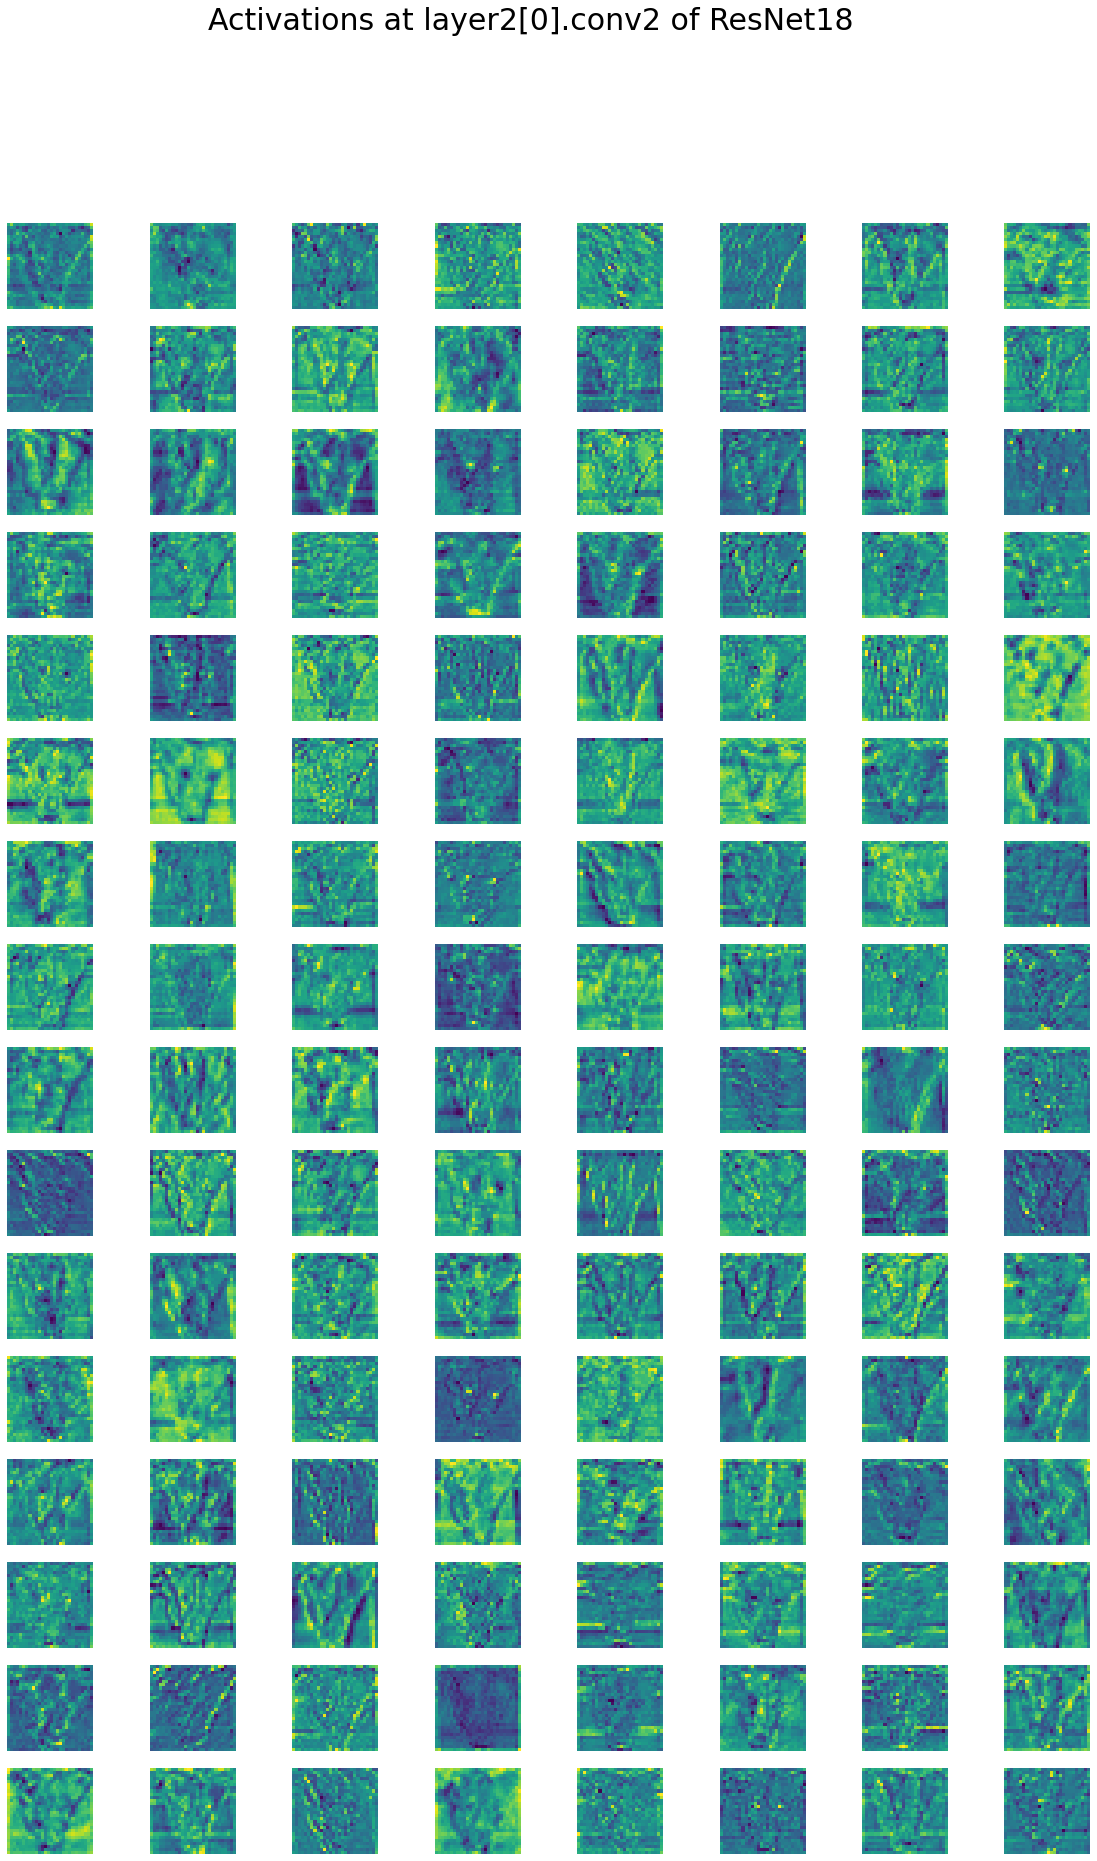

In [ ]:
f = plt.figure(figsize=(16, 8))

f.set_size_inches(20, 30)

activations = activations.squeeze()

# there are 128 out channels so let's visualise them in a 16*8 grid.
for i, activation in enumerate(activations):
    plt.subplot(16, 8, i + 1)
    plt.imshow(activation);
    plt.axis('off')

f.suptitle("Activations at layer2[0].conv2 of ResNet18", fontsize=30)
plt.show()

#### Comparing ResNet with the first layers of VGG and AlexNet

In [ ]:
vgg19 = models.vgg19(pretrained=True)
alexnet = models.alexnet(pretrained=True)


/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

In [ ]:
# Get first layer weights of vgg
print(vgg19.features[0])
vgg_weights = vgg19.features[0].weight.detach().numpy()
print(vgg_weights.shape)

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(64, 3, 3, 3)


In [ ]:
#normalising weights so a value of 0 becomes gray, and colours stay within [0,1]
def normalise_weights(weights):
    return weights / (np.abs(weights).max()) / 2 + 0.5


def visualise_weights(weights, figsize, title):
    f = plt.figure(figsize=figsize)
    #there are 64 convolution kernels, which we will arrange along an 8x8 grid
    for i, w in enumerate(weights):
        plt.subplot(figsize[0], figsize[1], i + 1)
        # we move the colour channel axis to the end, this is where imshow expects it
        plt.imshow(np.moveaxis(w, 0, -1));
        plt.axis('off')
    f.suptitle(title)
    plt.show()

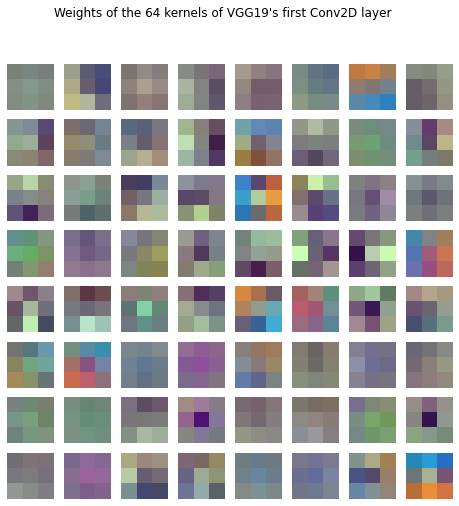

In [ ]:
visualise_weights(normalise_weights(vgg_weights), (8, 8), "Weights of the 64 kernels of VGG19's first Conv2D layer")

In [ ]:
print(alexnet.features[0])
alexnet_weights = alexnet.features[0].weight.detach().numpy()
print(alexnet_weights.shape)

Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
(64, 3, 11, 11)


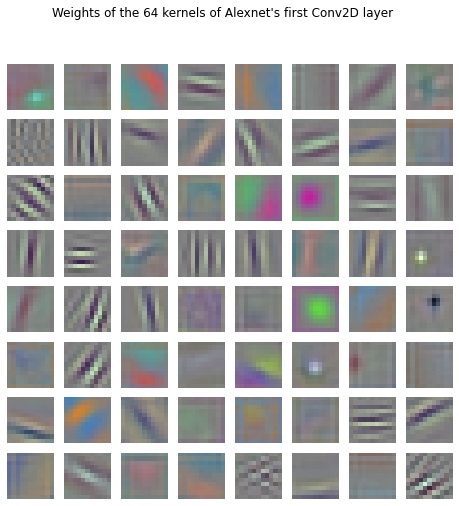

In [ ]:
visualise_weights(normalise_weights(alexnet_weights), (8, 8),
                  "Weights of the 64 kernels of Alexnet's first Conv2D layer")

**Interpretation**

*Visualise the convolution weights (also called kernels) in the first convolution layer of a pretrained AlexNet and a VGG19 network. Compare it to what we obtained the ResNet above. Document the similarities and differences do you notice.*

If we visualise the kernels on the first convolution layer of each of the three networks, the first thing we notice is that with time, the convolution kernels used in literature have become smaller and smaller. While AlexNet used an 11 * 11 one, VGGNet and ResNet opted for much smaller ones (3 and 5 respectively).

It seems like the first kernels learnt in AlexNet and in ResNet 18 are very similar. In fact, it doesn't seem like AlexNet has learnt much more complicated features than ResNet did despite it having much bigger convolution kernels. The kernels are all very smoooth and clear, and we distinguish two "types" of Kernels, one with a Zebra-like pattern (interleaved white and black strips) corresponding to sharp gradient changers, which might act as edge detector, and another one with a big coloured area in some part of the Kernel, which looks like something similar to a Gaussian kernel (focus in the centre).

These are patterns not seen in VGG's first layer, because the kernels are only of size 3 * 3. This is in a way to be expected -- one of VGG's contributions at the time was the realisation that deeper convolution networks with smaller kernels perform as well with shallower ones with bigger kernels, but can be more efficient in terms of time and space complexity. Nevertheless, there are familiar patterns which emerge: some kernels seem to have a clear progression of colours (from light to dark) along some axis, which correspond to a way of doing edge detection. Kernels (2, 4), (4, 7), (3, 1), (5, 4) look like four rotated instances of the same kernel, so performing the same function just in different directions. This observation is also true for AlexNet and ResNet, to a lesser extent.



## Editing models

Models can be edited rather flexibly in pytorch. Underlying a pytorch `Module` are python `OrderedDict` objects. These are ordered lists of key-value pairs. Each submodule and each parameter has a name, which is the key. Members of the dictionay can be accessed as attributes of the `Module`. Adding a new parameter or layer to a module will add a new key-value pair to this dictionary.

Let's try adding a new operation to our resnet18, which converts the logits to probabilities. We will do this by replacing the final operation by a `Sequential` module, which chains multiple operations together.

In [ ]:
from torch.nn import Softmax, Sequential

model = copy.deepcopy(resnet18)
model.fc = Sequential(
    model.fc,
    Softmax(dim=1)
)

In [ ]:
#let's see what the model looks like now
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Let's check the model still works and that it outputs a vector of probabilities which therefore sums to one.

In [ ]:
y = model(x)
print(y.sum())

tensor(1.0000, grad_fn=<SumBackward0>)


We can also replace existing layers with other layers. Here, for example, I replace the first convolution layer with a randomly initialized one of the same dimensions. We can check what effect this has on the classification of Blas:

In [ ]:
from torch.nn import Conv2d

model = copy.deepcopy(resnet18)
model.conv1 = Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
y = model(x)
top_5_classes(y)

[('spider web', 0.17406353),
 ('toilet paper', 0.07626264),
 ('shower curtain', 0.07611172),
 ('window shade', 0.04588212),
 ('paper towel', 0.044998366)]

Or, if we replace the convolutional layer by the convolutions from the VGG19 network, followed by a MaxPooling, to account for the difference in stride, the network becomes pretty certain that Blas is, in fact, spider web, or possibly a type of spider.

In [ ]:
from torch.nn import MaxPool2d

vgg19 = models.vgg19(pretrained=True)

model = copy.deepcopy(resnet18)
model.conv1 = Sequential(
    vgg19.features[0],
    MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False))
y = model(x)
top_5_classes(y)

[('spider web', 0.90654695),
 ('barn spider', 0.038704738),
 ('European garden spider', 0.013483326),
 ('window screen', 0.011457848),
 ('wolf spider', 0.0041355486)]

## Question C.2: Dropping layers in ResNet15

*3 marks*

ResNets have a peculiar property. Because of the skip-connections, one can in fact remove nonlinear layers from the network without effecting the network's behaviour too much. In the next two questions you will explore what happens when you do.

This question is composed of several tasks:
1. Delete the second `BasicBlock` from `layer4` of the ResNet18, and see how the network's predictions change.
1. Delete the first `BasicBlock` from `layer4` of the ResNet18, and see how the network's predictions change. (Note, this is a bit morer involved than the previous one).
1. Delete the first `BasicBlock` from `layer2` of the ResNet18, and see how the network's predictions change.

Tips:
* There are several ways for removing a ResNet block:
  * The easiest perhaps is to replace the entire block with a `torch.nn.Identity`. This works for blocks where the output and input featuremap size are the same. However, some of the residual blocks also reduce the size of the image (strided convolutions, or Max Pooling), so replacing by the Identity won't work. This is why the second task is a bit harder than the first. To find out what you have to do in the second task, look closely at the difference between the two `BasicBlock` instances within `layer4`. To understand how this block works, you can also look at the [source code](https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py#L67).
  * Since the activations are all ReLU, you can also ignore the effect of layers by setting appropriate weights and biases to zero. This is because $\operatorname{ReLU}(0z).= 0$. However, if you are trying to use this method, be aware of batch normalization layers - you also want to remove the effect of those.
  * You will notice that the layers of ResNets are of `torch.nn.Sequential` type. You can drop an element from this by creating a new `Sequential` instead with one operation removed.
* You can solve this task using a few lines of code only.

### Answer C.2

Please provide your answer in the code blocks below.

In [ ]:
from torch.nn import Identity

#1. dropping layer4 second block
model = copy.deepcopy(resnet18)

# Replace with identity (which works for anything)
model.layer4[1] = Identity()

# New predictions
y = model(x)
top_5_classes(y)

[('Italian Greyhound', 0.0016954434),
 ('Boston Terrier', 0.0016745134),
 ('Basenji', 0.0016514724),
 ('space heater', 0.0016252268),
 ('Cardigan Welsh Corgi', 0.0015921458)]

The network still predicts dog breeds, but with much lower probability

For the next task (removing the first block), we observe in the source code of resnet that the skip connection is represented as a downsampling layer, which is considered to be "identity": `identity = self.downsample(x)` ([Link here](https://github.com/pytorch/vision/blob/7d2acaa7d7fc600fa08fca18e9230f8651147025/torchvision/models/resnet.py#L158)). Thus this downsampling module should accomplish exactly what I want: go through the skip connection by default.

In [ ]:
#2. dropping layer4 first block
# A basic block runs through the blocks, and adds the downsampled version
# of the input as `identity`, so here we just have to replace layer4[0] by
# its downsampling layer.
model = copy.deepcopy(resnet18)
model.layer4[0] = model.layer4[0].downsample
y = model(x)
top_5_classes(y)

[('Greater Swiss Mountain Dog', 0.55931085),
 ('St. Bernard', 0.40826815),
 ('Black and Tan Coonhound', 0.029529301),
 ('English foxhound', 0.002143392),
 ('Rottweiler', 0.0006114693)]

The network predicts dog breeds but seems much more confident (in the sense that the probabilities are higher) about its judgement.

In [ ]:
#3. dropping layer2 first block
# Same as above.
model = copy.deepcopy(resnet18)
model.layer2[0] = model.layer2[0].downsample
y = model(x)
top_5_classes(y)

[('gas mask', 0.058007285),
 ('spatula', 0.050563186),
 ('golf ball', 0.040495727),
 ('match', 0.033017024),
 ('spotlight', 0.026302414)]

The network fails to predict that it's a dog and thinks the most likely thing the picture represents is a _mask_, with low confidence

## A convenience function: flattening ResNets

Residual blocks in pytorch ResNets are organised into 4 layers. I found this rather cumbersome for the next exercise we are going to do. In order to make ResNets easier to work with I created the convenience function below which can *flatten* the layer hierarchy of pytorch resnet models, merging the 4 layers into one, called `residual_blocks`. After flattening, instead of accessing `model.layer1[0]` you can do `model.residual_blocks[0]`.

In [ ]:
from torch import nn
from collections import OrderedDict


def flatten_resnet(resnet_model):
    """
    Takes a pytorch resnet model and returns a copy of the same model in a
    flattened format, where the residulal blocks are not divided into four layers
    but are instead all in a residual blocks component.
    """
    model = copy.deepcopy(resnet_model)
    residual_blocks = nn.Sequential(*model.layer1,
                                    *model.layer2,
                                    *model.layer3,
                                    *model.layer4)
    return nn.Sequential(OrderedDict([
        ('conv1', model.conv1),
        ('bn1', model.bn1),
        ('relu', model.relu),
        ('maxpool', model.maxpool),
        ('residual_blocks', residual_blocks),
        ('avgpool', model.avgpool),
        ('flatten', nn.Flatten()),
        ('fc', model.fc)
    ]))

## Question C.3: Which layer of ResNet50 is most important?

*3 marks*

We can use the layer-dropping procedure to understand the relative importance of each layer in achieving a correct classification for a specific input.

Load a pretrained ResNet50, and evaluate the model's predictions on the photo of Blas. Does it get the breed correct? (Border Collie).

Look at the structure of the ResNet50. Identify the `Bottleneck` blocks which are used instead of `BasicBlock` building blocks in deeper ResNets. These are still arranged into 4 'layers', and there are 16 of them in total.

Drop each of the 16 `Bottleneck` blocks from the ResNet50 (one at a time, not all at once), and make predictions with each of the perturbed networks. Plot the predicted probability of the Border Collie class (ImageNet class number 232) as a function of the index of the layer dropped. Compare the probabilities you get with the probability for the unperturbed model. What do you see?

### Answer C.3

Please add text in this box, and use as many code cells below as you'd like.

In [ ]:
import torch

In [ ]:
resnet50 = models.resnet50(pretrained=True)
resnet50.eval()

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
# Does it get the breed correct? YES!
model = copy.deepcopy(resnet50)
y = model(x)
print(top_5_classes(y))
original_prediction = None
with torch.no_grad():
    p = softmax(y[0, :], dim=0)
    original_prediction = p[232]
print(original_prediction)

[('Border Collie', 0.26453617), ('collie', 0.18160026), ('Cardigan Welsh Corgi', 0.17722456), ('Whippet', 0.12113578), ('Australian Kelpie', 0.05963931)]
tensor(0.2645)


In [ ]:
flattened_resnet = flatten_resnet(resnet50)

In [ ]:
# We try to drop each basic block in turn
border_collie_probabilities = []
in_top_1 = []
in_top_5 = []
for i in range(len(flattened_resnet.residual_blocks)):
    model = copy.deepcopy(flattened_resnet)
    # Modify
    if model.residual_blocks[i].downsample is not None:
        model.residual_blocks[i] = model.residual_blocks[i].downsample
    else:
        model.residual_blocks[i] = torch.nn.Identity()
    y = model(x)
    with torch.no_grad():
        p = softmax(y[0, :], dim=0)
        border_collie_probabilities.append(p[232])
        in_top_1.append(232 in p.topk(1).indices)
        in_top_5.append(232 in p.topk(5).indices)
        # print(top_5_classes(y))

border_collie_probabilities

[tensor(0.2405),
 tensor(0.1404),
 tensor(0.3190),
 tensor(0.0065),
 tensor(0.2325),
 tensor(0.4490),
 tensor(0.5044),
 tensor(0.1964),
 tensor(0.0969),
 tensor(0.0296),
 tensor(0.0932),
 tensor(0.0748),
 tensor(0.1922),
 tensor(0.0008),
 tensor(0.0941),
 tensor(0.0324)]

In [ ]:
list(zip(border_collie_probabilities, in_top_5, in_top_1))

[(tensor(0.2405), True, False),
 (tensor(0.1404), True, False),
 (tensor(0.3190), True, True),
 (tensor(0.0065), False, False),
 (tensor(0.2325), True, True),
 (tensor(0.4490), True, True),
 (tensor(0.5044), True, True),
 (tensor(0.1964), True, False),
 (tensor(0.0969), True, False),
 (tensor(0.0296), False, False),
 (tensor(0.0932), True, False),
 (tensor(0.0748), True, False),
 (tensor(0.1922), True, False),
 (tensor(0.0008), False, False),
 (tensor(0.0941), True, False),
 (tensor(0.0324), True, True)]

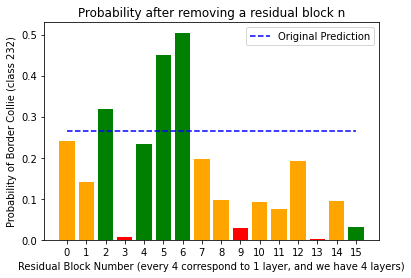

In [ ]:
x_range = (np.arange(16))
# Bar becomes orange if not top 1, and red if border collie not in top 5, otherwise green.
colors = ["red" if not in_top_5[i] else ("orange" if not in_top_1[i] else "green") for i in range(16)]
plt.bar(x_range, border_collie_probabilities, color=colors)
plt.plot(x_range, 16 * [original_prediction], '--b', label="Original Prediction")
plt.title("Probability after removing a residual block n")
plt.xlabel("Residual Block Number (every 4 correspond to 1 layer, and we have 4 layers)")
plt.ylabel("Probability of Border Collie (class 232)")
plt.xticks(x_range)
plt.legend()
plt.show()

**Interpretation**

Note that in the above bar chart, green means that Border Collie is the top 1 choice, orange means that it is in the top 5 choices, and red means it is not in any of those choices.

With 3 exceptions, removing residual blocks decreases the probability of the prediction being Border Collie wrt the unperturbed model, and we fail to get border collie as first choice in most cases when this happens. The most "important" layers turn out to be layers 3 (`layer1[3]`), 9 (`layer3[1]`) and (especially) 13 (`layer4[1]`), because after removing them, Border Collie isn't even in the top 5 list anymore, and the probability of the prediction "Border Collie" has gone down to very low.

However, interestingly, removing layer 15 (`layer4[3]`), although it lowers the probability of "Border Collie" very significantly to 0.0324, seems to decrease all the other probabilities too, such that "Border Collie" remains (surprisingly) the top prediction.

Finally, removing layers 2 (`layer1[2]`), 5 (`layer2[1]`), and 6 (`layer2[2]`) actually make the prediction "Border Collie" have much higher probability (around .4-.5). This is actually to be expected, because as we have a residual network (with skip connections), every layer's output is _added_ onto the residual stream, so we can expect that certain layers are good in other tasks and bad at this particular one, so actually make the prediction worse for this particular Border Collie task in favour of other tasks -- and despite that we can still get Border Collie as top prediction, thanks to skip connections. This would explain why replacing them entirely by skip connections (deleting them) might make the "performance" for this particular task better.

## Question C.4: Adversarial Examples

*6 marks*

Convolutional networks are shown to be very sensitive to perturbations to their input image. It is possible to change an image very slightly, so slightly that a human wouldn't notice any change, while fooling the network into misclassifying the image.

The following famous example is taken from [Explaining and Harnessing Adversarial Examples](https://arxiv.org/abs/1412.6572) by Goodfellow et al.:

![Illustration of adversarial examples](https://www.tensorflow.org/static/tutorials/generative/images/adversarial_example.png)

Your task is to
1. Implement the fast gradient sign method, and generate an adversarial input to a network of your choice ased on the image of Blas.
1. Implement the iterated fast gradient sign method, and generate an adversarial image based on Blas.
1. Document what you find. Was the attack successful?

### Answer C.4

Please add text in this box, and use as many code cells below as you'd like.

(*Sorry indeed, I have quite a few text boxes below too.*)

The attack I want to perform is on the original, down-scaled image but without the normalisation, because we want to try to perform an attack on the image, and see how well this attack might go, while seeing if there might be some artefacts apparent on the image due to the pertubation.

In [ ]:
# get resnet50
resnet50 = models.resnet50(pretrained=True)
resnet50.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

#### FGSM

I shall assume ResNet is trained on Cross-Entropy loss and try to do an adversarial attack on ResNet50.

We want to find a perturbation $\eta$, given by $η = \epsilon sign (∇xJ(θ, x, y))$, which, when added to a otherwise correctly classified picture, will be misclassified.

We switch to eval mode as we're attacking a model on eval mode.

In [ ]:
# Work directly on the resized original image, xx

transform_ = transforms.Compose([transforms.Resize(255),
                                 transforms.CenterCrop(224),
                                 transforms.ToTensor()])

xx = transform_(img)

xx = xx.unsqueeze(0)

# Define normalisation separately.
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

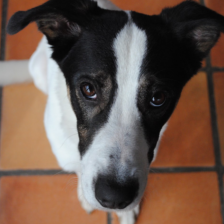

In [ ]:
# Check original image
transforms.ToPILImage()(xx.squeeze())

In [ ]:
# Check that it works.
with torch.no_grad():
    y = resnet50(normalize(xx))
    print(top_5_classes(y))

[('Border Collie', 0.26453617), ('collie', 0.18160026), ('Cardigan Welsh Corgi', 0.17722456), ('Whippet', 0.12113578), ('Australian Kelpie', 0.05963931)]


In [ ]:
from torch.nn import CrossEntropyLoss

# Adversarial attack.
model = copy.deepcopy(resnet50)

class_number = 232

loss = CrossEntropyLoss()


# Attack
def gen_eta(model, epsilon, x, class_number):
    # setup
    y_expected = torch.zeros(1000)
    with torch.no_grad():
        y_expected[class_number] = 1
        y_expected = y_expected.unsqueeze(0)
    # Copy x to set requires gradient to true
    x_copy = copy.deepcopy(x)
    x_copy.requires_grad = True

    x_normalized = normalize(x_copy)
    # Compute gradient
    y = model(x_normalized)
    loss_res = loss(y, y_expected)
    loss_res.backward()
    x_grad = x_copy.grad
    return (epsilon * torch.sign(x_grad)).detach().numpy()


In [ ]:
# Magic 0.007 from the paper given above.
eta = gen_eta(model, .007, xx, class_number)
eta

array([[[[-0.007,  0.007,  0.007, ..., -0.007, -0.007,  0.007],
         [ 0.007, -0.007, -0.007, ...,  0.007, -0.007, -0.007],
         [ 0.007, -0.007,  0.007, ..., -0.007, -0.007, -0.007],
         ...,
         [-0.007, -0.007, -0.007, ...,  0.007,  0.007, -0.007],
         [ 0.007, -0.007, -0.007, ...,  0.007,  0.007, -0.007],
         [-0.007,  0.007,  0.007, ..., -0.007, -0.007,  0.007]],

        [[-0.007, -0.007,  0.007, ..., -0.007,  0.007,  0.007],
         [-0.007, -0.007, -0.007, ...,  0.007, -0.007, -0.007],
         [-0.007, -0.007, -0.007, ..., -0.007, -0.007, -0.007],
         ...,
         [-0.007, -0.007, -0.007, ...,  0.007,  0.007, -0.007],
         [ 0.007, -0.007, -0.007, ...,  0.007,  0.007, -0.007],
         [-0.007, -0.007, -0.007, ..., -0.007, -0.007,  0.007]],

        [[-0.007, -0.007,  0.007, ..., -0.007,  0.007,  0.007],
         [ 0.007,  0.007, -0.007, ...,  0.007, -0.007, -0.007],
         [ 0.007, -0.007,  0.007, ..., -0.007, -0.007,  0.007],
        

In [ ]:
top_5_classes(model(xx + eta))

[('Italian Greyhound', 0.9844919),
 ('Whippet', 0.006444748),
 ('Basenji', 0.00614178),
 ('Boston Terrier', 0.0006482278),
 ('toy terrier', 0.00058137585)]

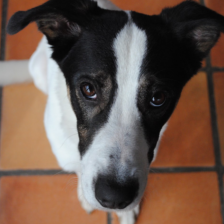

In [ ]:
# Original input
transforms.ToPILImage()(xx.squeeze())

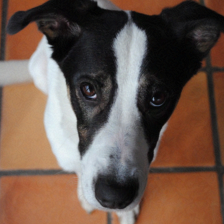

In [ ]:
# Perturbed input
transforms.ToPILImage()((xx + eta).squeeze())

This seems like it's working: the adversarial image still looks like a border collie but the model predicts Italian Greyhound whp, and the perturbede image doesn't have obvious artefacts. Now what if we add even more perturbations?



In [ ]:
# Perturbation with growing epsilon
epsilons = torch.tensor([1, 2, 4, 8, 16]) / 255  # Equivalent epsilons to the below section, scaled by 255
top_5s = []
perturbed_xs = []
for epsilon in epsilons:
    perturbed_x = xx + gen_eta(model, epsilon, xx, class_number)
    perturbed_xs += [perturbed_x]
    top_5s += [top_5_classes(resnet50(perturbed_x))]

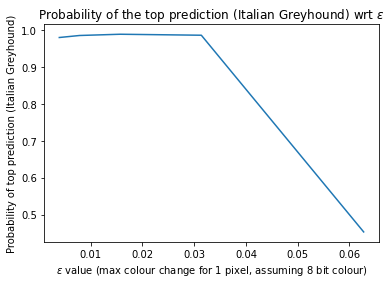

In [ ]:
assert all(res_i[0][0] == 'Italian Greyhound' for res_i in top_5s)
plt.plot(epsilons, [res_i[0][1] for res_i in top_5s])
plt.xlabel("$\epsilon$ value")
plt.ylabel("Probability of top prediction (Italian Greyhound)")
plt.title("Probability of the top prediction (Italian Greyhound) wrt $\epsilon$")
plt.show()

In [ ]:
# Why has the top prediction's accuracy gone down?
top_5_classes(resnet50(perturbed_xs[-1]))

[('Italian Greyhound', 0.45320216),
 ('mosquito net', 0.21883449),
 ('Boston Terrier', 0.08181242),
 ('Basenji', 0.07456205),
 ('bath towel', 0.048272964)]

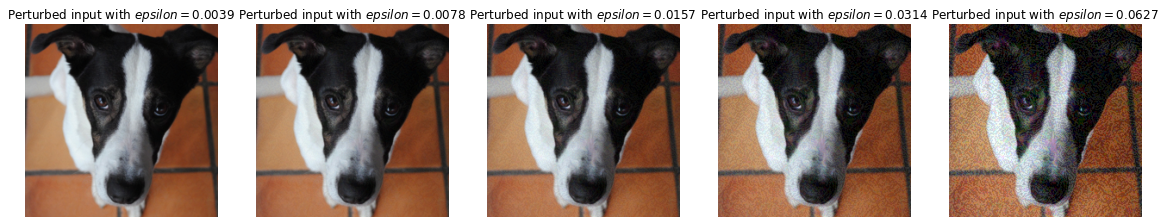

In [ ]:
fig, axs = plt.subplots(1, len(epsilons), figsize=(20, 50))
for i, ax in enumerate(axs):
    ax.imshow(np.moveaxis(perturbed_xs[i].squeeze().detach().numpy(), 0, -1))
    ax.set_title(f"Perturbed input with $epsilon={round(float(epsilons[i]), 4)}$")
    ax.axis('off')
plt.show()

The perturbations here are added in a way so that the epsilon values (in the same order) are comparable to those in the next section: we imagine a maximum change of colour value of $ϵ' \in [0, 255]$ which we scale down to $\epsilon\in[0, 1]$ by dividing by 255. Clearly here as we add more and more perturbation, the input looks more and more fuzzy to the human eye and the attack becomes apparent. Interestingly though, the probability of the top prediction goes down drastically at $\epsilon=16/255 \approx 0.0627$: this is likely because we are getting close to leaving the subspace for the Italian Greyhound subcategory!

#### I-FGSM
https://arxiv.org/pdf/1611.01236.pdf

I shall use the basic iterative method presented in the paper above, which is essentially clipped gradient-ascent.

$\textbf{X}_0^{adv}=\textbf{X}$,

$\textbf{X}_{N+1}^{adv}=Clip_{X, \epsilon}\{\textbf{X}_N^{adv} + \alpha \  \text{sign} (\nabla_X J(\textbf{X}_N^{adv}, y_{true}))\}$

The paper has chosen the number of iterations 'heuristically' and the parameters $\alpha$ and $\epsilon$ (both were between 0 and 255) rather arbitrarily (before doing experiments on them): I shall implement exactly what was suggested by the paper via some scaling: scaling down both $\alpha$ and $\epsilon$ by 255 would work because we know our input (original image, scaled down but NOT NORMALISED) has all its values between 0 and 1.

In [ ]:
from torch.nn import CrossEntropyLoss

# Adversarial attack.
model = copy.deepcopy(resnet50)

class_number = 232

loss = CrossEntropyLoss()


def clip(x, epsilon, a):
    to_return = torch.min(torch.tensor(1.),
                          torch.min(x + epsilon, torch.max(torch.tensor(0.), torch.max(x - epsilon, a))))
    return to_return


def iterative_fgsm(model, alpha, epsilon, x, class_number, iteration_number):
    y_expected = torch.zeros(1000)
    with torch.no_grad():
        y_expected[class_number] = 1
        y_expected = y_expected.unsqueeze(0)

    x_copy = copy.deepcopy(x)
    x_copy.requires_grad = True

    for _ in range(iteration_number):
        # Compute gradient
        y = model(x_copy)
        loss_res = loss(y, y_expected)
        loss_res.backward()
        x_grad = x_copy.grad
        with torch.no_grad():
            # Update x without gradient flow
            x_copy = clip(x, epsilon, x_copy + alpha * torch.sign(x_grad))
            x_copy.requires_grad = True

    return x_copy.detach().numpy()


def scale_hyper_params_and_ifgsm(model, alpha, epsilon, x, class_number):
    return iterative_fgsm(model, alpha / 255, epsilon / 255, x, class_number, round(min(epsilon + 4, 1.25 * epsilon)))

##### **Perturbing with I-FGSM**

Below is an execution of arbitrary places where we're clipping.

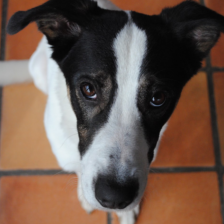

In [ ]:
# Original input
transforms.ToPILImage()(xx.squeeze())

[('Italian Greyhound', 0.9999999), ('Whippet', 1.2933586e-07), ('Mexican hairless dog', 6.166368e-09), ('toy terrier', 7.175515e-11), ('Miniature Pinscher', 4.2902404e-11)]


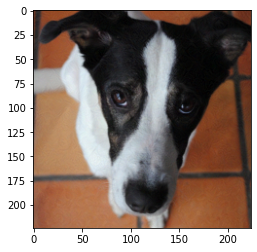

In [ ]:
# Perturbed input for epsilon = 4 and the `recommended number` of iterations in the https://arxiv.org/pdf/1607.02533.pdf paper
alpha = 1  # colour change rate for 1 pixel, assuming 8 bit colour
epsilon = 4
perturbed_x = scale_hyper_params_and_ifgsm(model, alpha, epsilon, xx, class_number)
print(top_5_classes(resnet50(torch.tensor(perturbed_x))))
plt.imshow(np.moveaxis(perturbed_x.squeeze(), 0, -1))

In [ ]:
# Perturbation with growing epsilon
alpha = 1
epsilons = [1, 2, 4, 8, 16]
top_5s = []
perturbed_xs = []
for epsilon in epsilons:
    perturbed_x = scale_hyper_params_and_ifgsm(model, alpha, epsilon, xx, class_number)
    perturbed_xs += [perturbed_x]
    top_5s += [top_5_classes(resnet50(torch.tensor(perturbed_x)))]

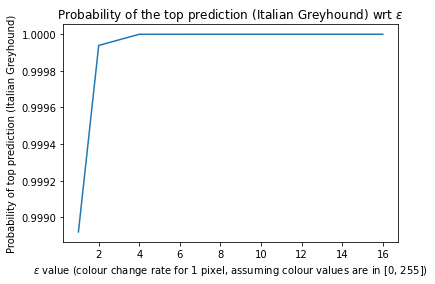

In [ ]:
assert all(res_i[0][0] == 'Italian Greyhound' for res_i in top_5s)
plt.plot(epsilons, [res_i[0][1] for res_i in top_5s])
plt.xlabel("$\epsilon$ value (colour change rate for 1 pixel, assuming colour values are in [0, 255])")
plt.ylabel("Probability of top prediction (Italian Greyhound)")
plt.title("Probability of the top prediction (Italian Greyhound) wrt $\epsilon$")
plt.show()

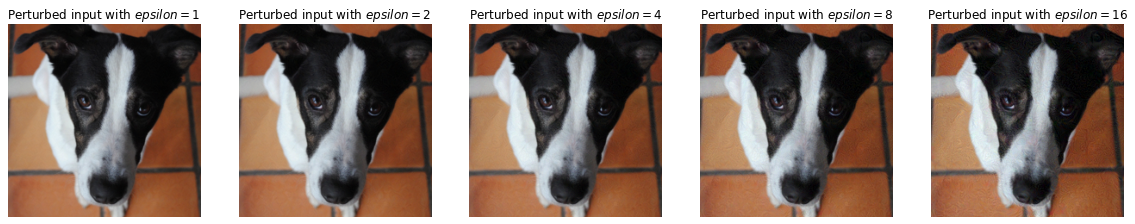

In [ ]:
fig, axs = plt.subplots(1, len(epsilons), figsize=(20, 50))
for i, ax in enumerate(axs):
    ax.imshow(np.moveaxis(perturbed_xs[i].squeeze(), 0, -1))
    ax.set_title(f"Perturbed input with $epsilon={epsilons[i]}$")
    ax.axis('off')
plt.show()

#### Findings

A few points:
- The attack works in both cases.
- Both methods tweaked $x$ in the same direction, increasing the probability for "Whippet" and decreasing that of "Border Collie". We are indeed monotonically going away from "Border Collie" in the output space by tweaking the input space, but we aren't controlling which direction we're going to and don't have control over what to make the model believe in.
- In the non-iterated version, with big enough $ϵ$ we may go arbitrarily far way from our original class (as shown by the graph above), but when we do so, the perturbations become apparent to human eyes.
- In the iterative case, perturbing iteratively seems to, as indicated by the [paper](https://arxiv.org/pdf/1607.02533.pdf), allow a much bigger perturbation margin $ϵ$ with better results (getting closer to probability of 1), as it seems to exploit (as indicated by the paper) "much finer perturbations" -- for my naive human eyes, $\epsilon$ at 16 does not actually look any different to the original image.


# D: Transformers vs PCFGs

In this part of the assignment, you will train simple language models on samples generated from probabilistic context-free grammars (PCFGs). These are just like CFGs (which I assume you know about) but each production rule has an associated probability. Thus, a PCFG defines not only a grammar (set of grammatical sentences), but a probability distribution over sentences.

## Setting up

We will set up this exercise by creating a dataset of strings containing balanced parentheses, and then fitting a simple Markov model to it.


### Creating a dataset

Below, I included a class which wraps a PCFG inside a pytorch `Dataset`. To define the PCFG itself, I install the `pcfg` python module, which is, in turn, based on `nltk`. This library allows us to define a PCFG by writing down production rules in a relatively self-explanatory string, and then draw samples from it.

Please refer to https://github.com/thomasbreydo/pcfg for examples and documentation.

In [ ]:
import numpy as np
from matplotlib import pylab as plt
# import pytorch_lightning as pl

In [ ]:
pip install pcfg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 6.6.0
    Uninstalling importlib-metadata-6.6.0:
      Successfully uninstalled importlib-metadata-6.6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
markdown 3.4.3 requires importlib-metadata>=4.4; python_version < "3.10", but you have importlib-metadata 3.10.1 which is incompatible.
gym 0.25.2 requires importlib-metadata>=4.8.0; python_version < "3.10", but you have importlib-metadata 3.10.1 which is incompatible.


In [ ]:
import torch
from pcfg import PCFG
from torch.utils.data import TensorDataset
from torch.nn.functional import pad
from torchtext.vocab import build_vocab_from_iterator
from torchtext.functional import to_tensor, truncate
from typing import Tuple


class PCFGDataset(TensorDataset):
    r"""Pytorch Dataset wrapping sentences sampled from a probabilistic
    context-free grammar (PCFG).

    Each sample will be generated from the PCFG supplied, truncated and padded
    to the required length, with characters encoded as distinct integers.

    This dataset contains source and target sequences, where the target sequence
    is the same as the source but shifted by one to the left. This is useful for
    self-supervised next token prediction tasks.

    Parameters
    ----------
    grammar : pcfg.PCFG
        PCFG object typically initialized from a string representing production
        rules
    n_samples : int
        Number of samples drawn from the PCFG. Defaults to 1024.
    seqlength : int
        Length of the sequences after truncation and padding. Defaults to 128.
    padchar : str
        Character used to pad strings. Defaults to a space character.

    Attributes
    ----------
    tensors: Tuple[torch.Tensor, ...]
        Pair of tensors representing source and target sequences, where the
        target sequence is the same as the source but shifted to the left by
        one.
    """
    tensors: Tuple[torch.Tensor, ...]

    def __init__(self, grammar: PCFG, n_samples: int = 1024, seqlength: int = 128, padchar: str = ' ') -> None:
        sentences = [sentence.replace(' ', '') for sentence in grammar.generate(n_samples)]
        vocab = build_vocab_from_iterator(''.join(sentences) + padchar)
        self.vocab = vocab
        indices = [vocab([c for c in sentence]) for sentence in sentences]
        T = to_tensor(truncate(indices, max_seq_len=seqlength + 1), padding_value=vocab[padchar])
        B, L = T.shape
        T = pad(T, (0, seqlength + 1 - L), 'constant', vocab[padchar])
        X = T[:, :-1]
        Y = targets = T[:, 1:]
        self.tensors = (X, Y.contiguous())

    def __getitem__(self, index: int):
        return tuple(tensor[index] for tensor in self.tensors)

    def __len__(self):
        return self.tensors[0].size(0)

    def decode_tensor(self, t: torch.Tensor):
        """Decodes a tensor of integers into strings. Useful for printing model
        generations."""
        itos = self.vocab.get_itos()
        return [''.join([itos[i] for i in sequence]) for sequence in t.tolist()]

    def get_vocab_size(self):
        """Returns size of vocabulary."""
        return len(self.vocab)

    def head(self, n: int):
        """Prints the string representation of the first n datapoints."""
        print('\n'.join(self.decode_tensor(self[:n][0])))

Let's create a mildly interesting dataset with this, using a D2 Dyck grammar, which generates balanced sentences of parantheses with two types of parentheses `()` and `[]`. Here, I will terminate strings with a `;`.

In [ ]:
dyck2_grammar = PCFG.fromstring("""
S -> S S [0.1] | "(" S ")" [0.3] | "[" S "]" [0.3] | "()" [0.15] | "[]" [0.15]
""")

dyck2_dataset = PCFGDataset(dyck2_grammar)

dyck2_dataset.head(10)

[[[]]]                                                                                                                          
[()]                                                                                                                            
[([[[([])]]])]                                                                                                                  
[(([[([[()]])][]()]))]                                                                                                          
[[()]]                                                                                                                          
(([()]))[]                                                                                                                      
[[[]]]                                                                                                                          
[[]]                                                                                             

### A simple Markov-model

Now we're going to create a simple discrete Markov chain, and fit it to our data. A Markov model makes a probabilistic prediction of the next token considering the last token only, thus:

$$
p(x_{t+1} \vert x_{1}, \ldots, x_t, \theta) = p(x_{t+1} \vert x_t, \theta) = \phi(\theta_{x_{t}, x_{t+1}}),
$$

where $\theta$ is a $V\times V$ matrix, $V$ represents the vocabulary size, i.e. the number of distinct values $x_t$ can take, and $\phi$ is the logistic sigmoid.

If you watch Andrej Karpathy's video [Let's build GPT: from scratch, in code, spelled out](https://www.youtube.com/watch?v=kCc8FmEb1nY), this is the same as what he refers to as the `BigramLangaugeModel`.

In [ ]:
from torch.nn.functional import cross_entropy, softmax


class DiscreteMarkovModel(torch.nn.Module):
    r"""Pytorch Module that implements a discrete markov chain with `vocab_size`
      discrete states.

      Parameters
      ----------
      vocab_size : int
          Number of states/vocabulary entries.
    """

    def __init__(self, vocab_size: int):
        super().__init__()
        self.embedding = torch.nn.Embedding(vocab_size, vocab_size)

    def forward(self, input: torch.Tensor, target: torch.Tensor):
        r"""Evaluates logits for the next token, as well as the cross entropy
        between these predictions and the actual target sequence observations.

        Parameters
            ----------
            input:
                torch integer tensor of size batchsize times sequence length.
            target:
                The second parameter.

            Returns
            -------
            logits: torch.Tensor
                Tensor containing logits for next token prediction.
            loss: torch.Tensor
                Tensor wrapping scalar loss for cross-entropy loss.
        """
        logits = self.embedding(input)

        B, L, V = logits.shape
        loss = cross_entropy(logits.contiguous().view(B * L, V), target.contiguous().view(B * L))

        return logits, loss

    def generate(self, input, num_new_tokens=1):
        input = input.detach()

        for _ in range(num_new_tokens):
            logits, _ = self(input, input)

            p = softmax(logits[:, -1, :], dim=-1)

            new_tokens = torch.multinomial(p, num_samples=1)

            input = torch.concatenate([input, new_tokens], dim=1).contiguous()

        return input

We now look at what a randomly initialized model generates:

In [ ]:
from torch.utils.data import random_split

markov_model = DiscreteMarkovModel(dyck2_dataset.get_vocab_size())
markov_model.to('cuda:0')

prefixes = dyck2_dataset[:10][0][:, :1].to('cuda:0')
generated_tensor = markov_model.generate(prefixes, num_new_tokens=20)

print('\n'.join(dyck2_dataset.decode_tensor(generated_tensor)))

[(  [ [ ])[])(( )[ [ 
[([(]])()]((] (]])](]
[ [ ]] ])])(])[ ]((]]
[)[)(] ]))[](](]]])[(
[ [)(])[ ]((])[](][ ]
(])])))[ )[ ]( ])([[ 
[(])[)])](])[[ ])])( 
[)[ ([[ ()[ ]()[)) ](
(]](])[ [ ][)])])( )(
[[ ]]]( )[])]((])())]


Clearly, the model's output doesn't look anything like our training data. Let's try training the model using a simple pytorch training loop.

In [ ]:
from torch.optim import Adam
from torch.utils.data import DataLoader

batch_size = 256
learning_rate = 1e-2
dyck2_dataset.tensors = tuple(tensor.to('cuda:0') for tensor in dyck2_dataset.tensors)
train_loader = DataLoader(dyck2_dataset, batch_size)
optimizer = Adam(markov_model.parameters(), lr=learning_rate)
for _ in range(1000):
    for x, y in train_loader:
        optimizer.zero_grad()
        _, loss = markov_model(x, y)
        loss.backward()
        optimizer.step()

Let's generate some output from the trained model.

In [ ]:
prefixes = dyck2_dataset[:10][0][:, :1].to('cuda:0')
generated_tensor = markov_model.generate(prefixes, num_new_tokens=20)

print('\n'.join(dyck2_dataset.decode_tensor(generated_tensor)))

[([[])]              
[[[(([([[())         
[])[(()              
[]]))                
[[([])               
()                   
[])                  
[]([([]]()]))((([[([[
([[]]                
[])                  


## Question D.1: Model evaluation

*3 marks*

The generated strings above look more reasonable than the random ones before, but most of the time they don't produce balanced parentheses. (This is not surprising as a Markov model has no memory). Let's quantify the performance as we develop our models.

1. Write code that evaluates the cross-entropy loss on a held-out test/validation dataset
1.  write code that evaluate the probability that a generated sentence is grammatical (i.e. that it is a valid member of the Dyck-2 language). I'll call this $\mathbb{P}(\mathcal{G})$.
1. plot training loss, validation loss, as well as $\mathbb{P}(\mathcal{G})$ as training progresses.

*Notes:*
* It's possible to overthink step 2. For clarity, the Monte Carlo method of generating several random samples then checking if if each sample is grammatical is accepted.
* you might find it easier to wrap this code into a function as you'll use it later.
* feel free to make use training libraries such as pytorch lightning or ignite.

### Answer D.1

please add answer in the code cell(s) below:

In [ ]:
# Validation and Test sets
dyck2_validation = PCFGDataset(dyck2_grammar, 256)
dyck2_test = PCFGDataset(dyck2_grammar, 256)

In [ ]:
def cross_entropy_for(model, dataset: PCFGDataset):
    _, loss = model(dataset[:][0].to("cuda:0"), dataset[:][1].to("cuda:0"))
    return loss

In [ ]:
with torch.no_grad():
    print(cross_entropy_for(markov_model, dyck2_validation))

tensor(0.0910, device='cuda:0')


We compute $\mathbb{P}(\mathcal{G})$ via Monte Carlo sampling. We fix a maximum number of tokens defaulted at 128 and only admit an example if it has reached the final state (4) (i.e. the padding char) in our case.

In [ ]:
def is_grammatical(seq: torch.Tensor):
    stack = []
    for index in seq:
        if index == 4:
            # We are done
            break
        elif index == 0:
            # If '(', add ')' to stack
            stack.append(1)
        elif index == 2:
            # If '[', add ']' to stack
            stack.append(3)
        elif len(stack) == 0 or (index != stack.pop()):
            # If ')' or ']', check top of stack, if empty or unequal return False
            return False
        # else continue
    return len(stack) == 0


assert all(is_grammatical(dyck2_dataset[:10][0][i]) for i in range(len(dyck2_dataset[:10][1])))
assert all(not is_grammatical(dyck2_dataset[:10][1][i]) for i in range(len(dyck2_dataset[:10][1])))

In [ ]:
def monte_carlo_probability_generated_is_correct(model: torch.nn.Module, max_n_samples: int = 1000,
                                                 max_n_new_tokens=127):
    # generate with uniform start of 0 or 2
    generated_start = ((torch.rand(max_n_samples, 1) > 0.5) * 2).to('cuda:0')
    generated_sequences = model.generate(generated_start, num_new_tokens=max_n_new_tokens)
    valid_sequences = 0
    total_complete_sequences = max_n_samples
    for seq in generated_sequences:
        if seq[-1] != 4:
            # Ignore incomplete sequences
            total_complete_sequences -= 1
        else:
            valid_sequences += int(is_grammatical(seq))
    return (valid_sequences / total_complete_sequences), valid_sequences, total_complete_sequences

In [ ]:
monte_carlo_probability_generated_is_correct(markov_model)

(0.08779011099899092, 87, 991)

In [ ]:
from tqdm.notebook import tqdm

batch_size = 256
learning_rate = 1e-2
markov_model = DiscreteMarkovModel(dyck2_dataset.get_vocab_size())
markov_model.to('cuda:0')

dyck2_dataset.tensors = tuple(tensor.to('cuda:0') for tensor in dyck2_dataset.tensors)
train_loader = DataLoader(dyck2_dataset, batch_size)

optimizer = Adam(markov_model.parameters(), lr=learning_rate)
train_losses = []
val_losses = []
proba_corrects = []
with tqdm(range(1000)) as t_global:
    for _ in t_global:
        losses = []
        for (x, y) in (train_loader):
            optimizer.zero_grad()
            _, loss = markov_model(x, y)
            loss.backward()
            optimizer.step()
            with torch.no_grad():
                losses += [loss.cpu().detach().numpy()]
        # Accumulate validation data
        with torch.no_grad():
            mean_train_loss = np.mean(losses)
            train_losses.append(mean_train_loss)
            val_loss = cross_entropy_for(markov_model, dyck2_validation).cpu().detach().numpy()
            val_losses.append(val_loss)
            proba_correct, _, _ = monte_carlo_probability_generated_is_correct(markov_model, max_n_samples=200)
            proba_corrects.append(proba_correct)
            t_global.set_postfix(
                {'Train loss': mean_train_loss, 'Val loss': val_loss, 'Proba Gen Correct': proba_correct})

  0%|          | 0/1000 [00:00<?, ?it/s]

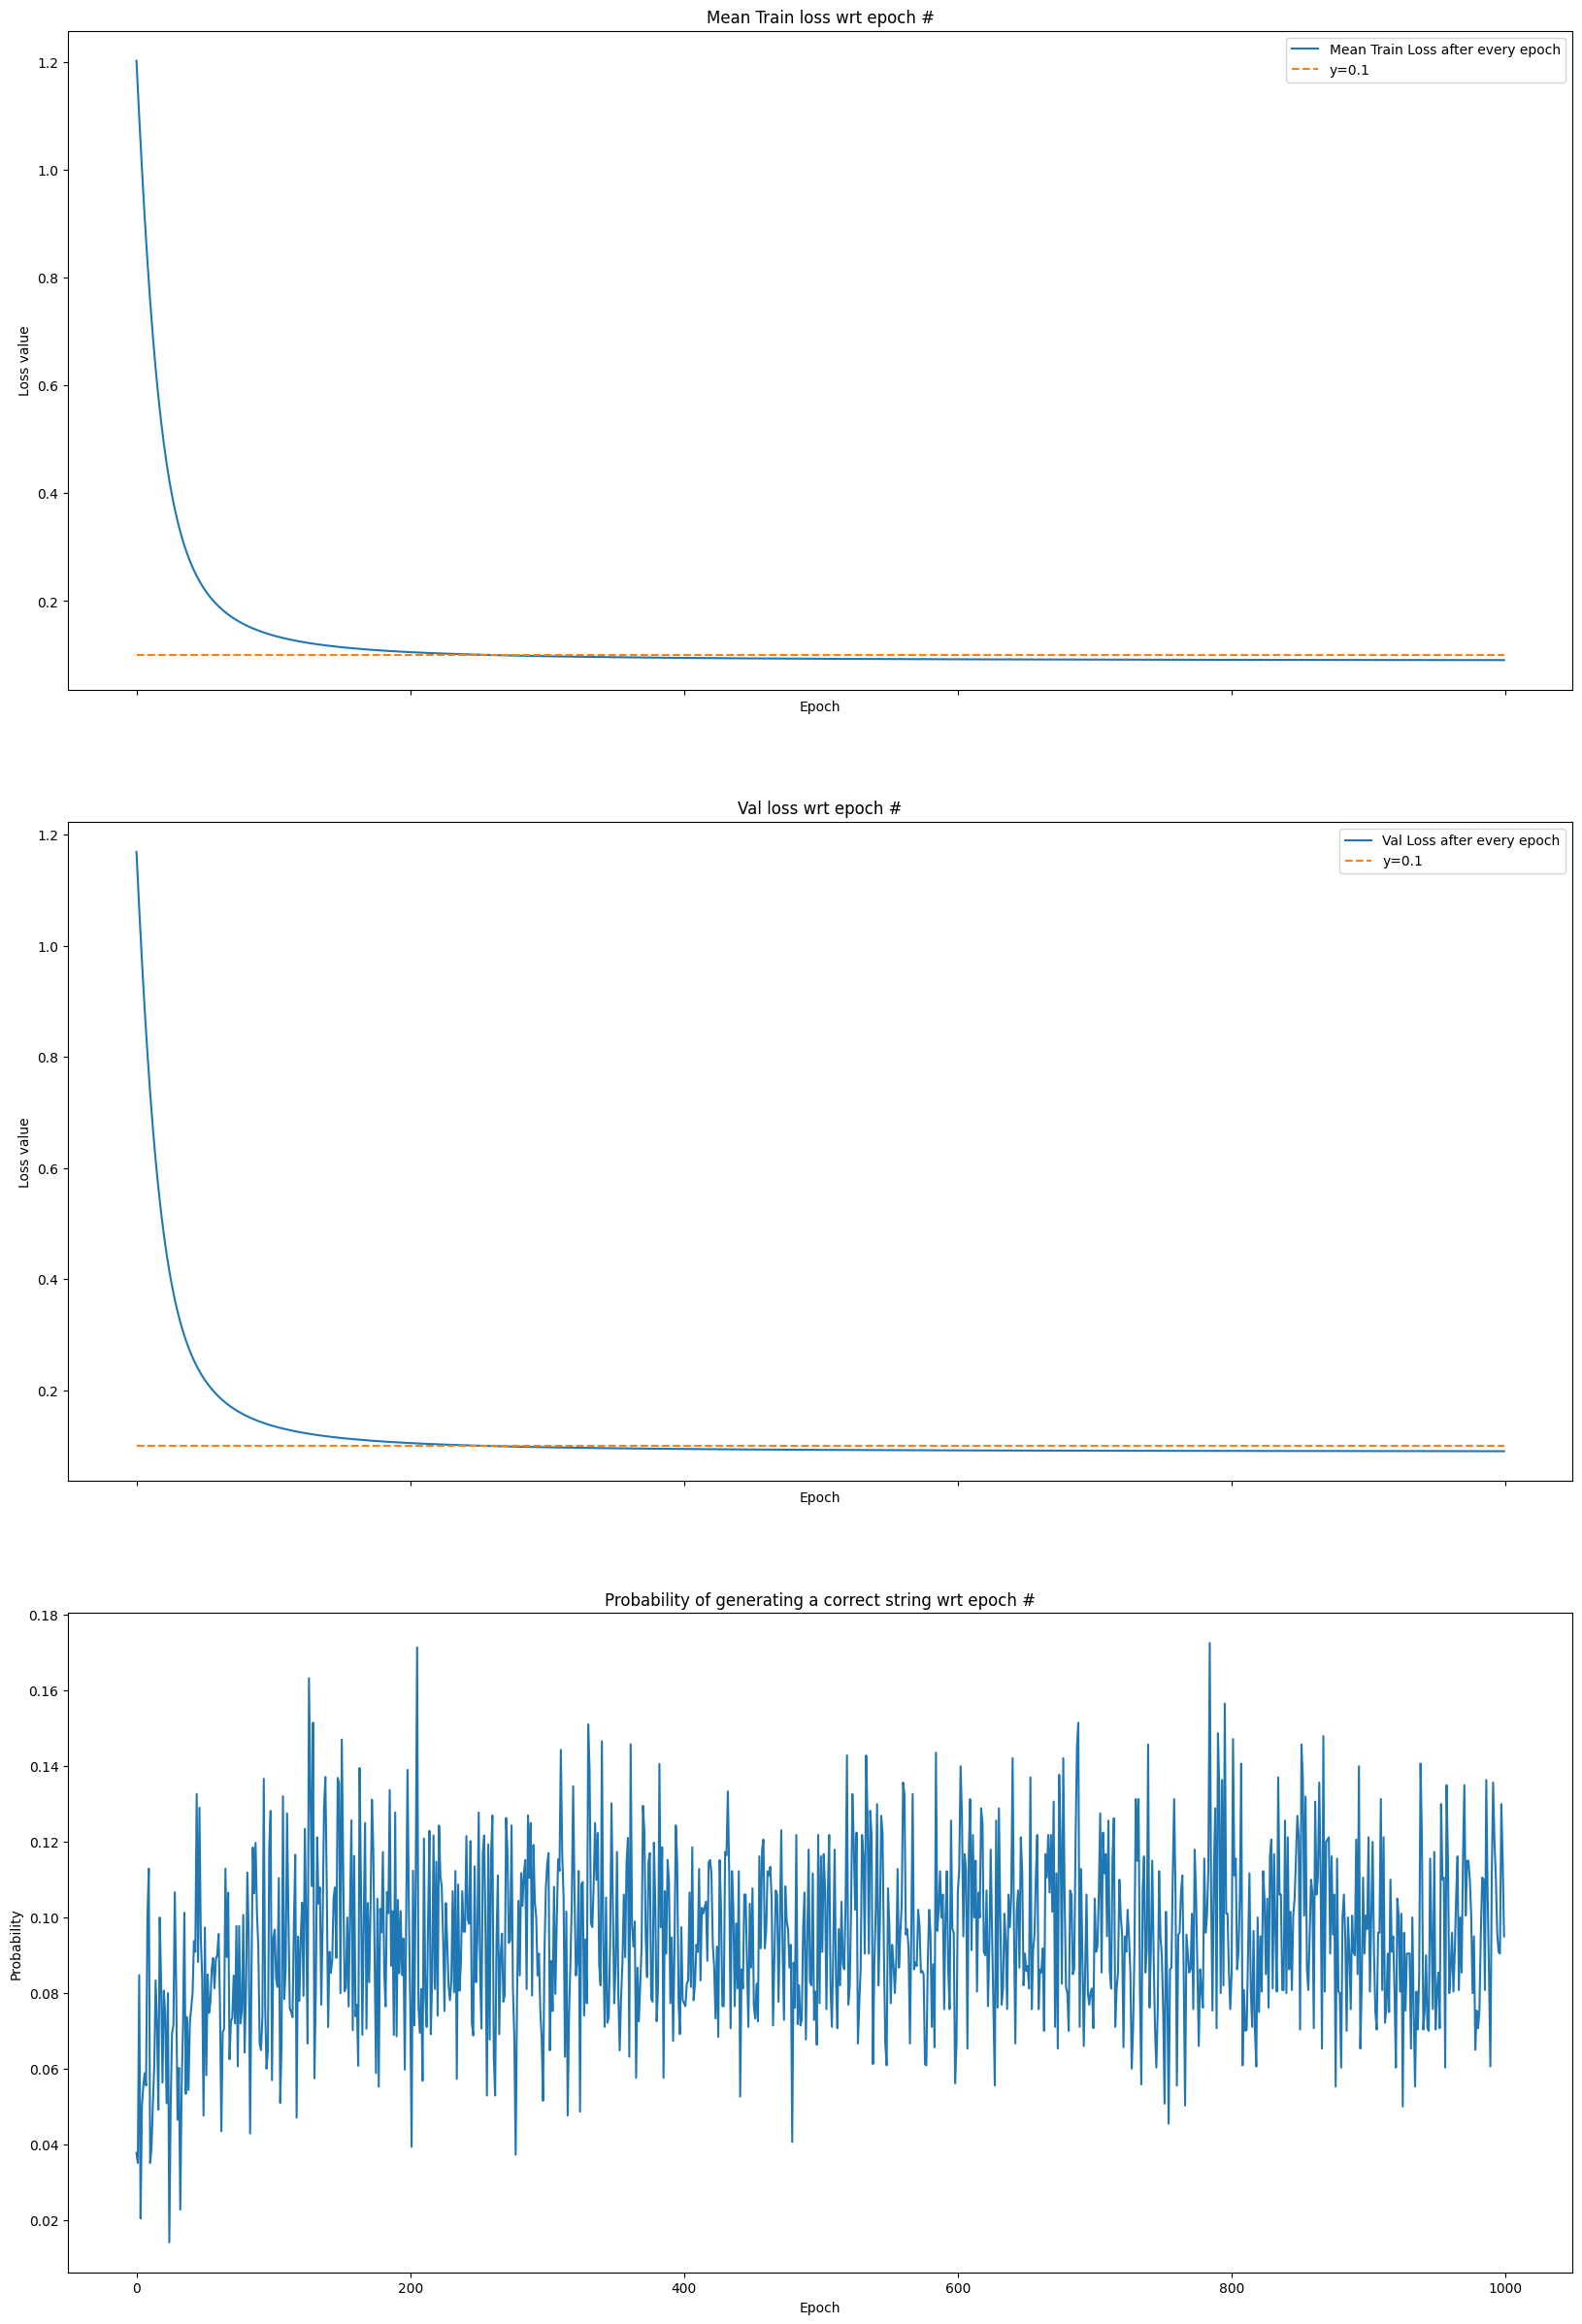

In [ ]:
# Graphs as training progresses
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(20, 30))
axs[0].plot(range(1000), train_losses, label="Mean Train Loss after every epoch")
axs[0].plot(range(1000), 1000 * [0.1], "--", label="y=0.1")
axs[0].set_title("Mean Train loss wrt epoch #")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss value")
axs[0].legend()

axs[1].plot(range(1000), val_losses, label="Val Loss after every epoch")
axs[1].plot(range(1000), 1000 * [0.1], "--", label="y=0.1")
axs[1].set_title("Val loss wrt epoch #")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Loss value")
axs[1].legend()

axs[2].plot(range(1000), proba_corrects, label="Probability of generating a correct string after every epoch")
axs[2].set_title("Probability of generating a correct string wrt epoch #")
axs[2].set_xlabel("Epoch")
axs[2].set_ylabel("Probability")

plt.show()

In [ ]:
# Final values to report
with torch.no_grad():
    print(f"Test loss: {cross_entropy_for(markov_model, dyck2_test).cpu().detach().numpy()}")
    print(
        f"Test proba of generating a correct string: {monte_carlo_probability_generated_is_correct(markov_model, max_n_samples=1000)[0]}")

Test loss: 0.0898137018084526
Test proba of generating a correct string: 0.08433734939759036


## Question D.2: Train a Transformer

*6 marks*

Now that we have evaluated the performance of our (rather naive) baseline model, let's build a shallow decoder-only transformer and see if it does better.

1. Define a shallow decoder-only transformer model using `torch` layer types. Tables 1 and 2 of [Gail's paper](https://arxiv.org/abs/2106.06981) suggest that a related task is solvable in RASP with 3 layers and 1 attention head. Start with the smallest model you think works.
1. Verify and demonstrate that your model uses causal attention correctly: Input at time $t$ should only influence output at time $s$ only if $t\leq s$. In the RNN lecture, we used backpropagation to check the influence of input at time $t$ on the output at time $T$ - this same idea may be used here.
1. Train the transformer model on the Dyck-2 language.
1. Evaluate the model, and contrast with the Markov model.

Notes:
* A decoder-only transfomer is composed of token and position embeddings as the first operation, these are followed by causal transformer layers, finally a linear readout head outputs logits in the same format as the Markov-model.
* By causal transformer layer I mean one that contains a Masked Self-Attention layer (with a triangular mask so each token only aggregates information from the past but not the future), a feed forward layer, layer normalization and skip connections.
* The original transformer used layer normalization after the other operations, later it's been observed that it's better to normalize before the operations. The pytorch layers have a flag for this, you can try it both ways.
* Note that the `TransformerEncoderLayer` supports attention masking. The `TransformerDecoderLayer` also includes cross-attention which is not needed here. So although you're building a decoder-only model, you may find that `TransformerEncoderLayer` is easier to use.
* I created the dataset so the first dimension of the tensors is the batch, the second dimension is position in the sequence. You may have to use the `batch_first` flag to tell layers to expect input in this format.
* If you really struggle with this, try a simpler dataset, or use an RNN or other architecture instead.

### Answer D.2:

The framing of the problem will be that of modelling the language of all strings in dyck2 (with an arbirarily long padding) to length 128.

This justifies the choice of leaving the padding there in both the Markov Chain baseline and the current model.

#### Defining a transformer

Gail's paper indicates that the Dyck2-PTF task can be solved by 3 attention layers, each with 1 head. This task is similar to the one of next token prediction, in the sense that we can reduce the generation of the next token to that of tagging: given a sequence, we can tag it, and if it has a P or a T. If it is a T, we can either just terminate the sequence with " " or add in an _opener_; if it is a P, we can add either of the closers, tag the new token, and choose the one which results in either P or T; if it is an F, we can just give up.

Therefore Dyck2 next-token prediction should be at least as hard as Dyck2-PTF -- let's see if we can have a smilar result experimentally.


Btw, in the `torch.nn.TransformerEncoderLayer` implementation the `src_mask` param in forward is used as the `attn_mask` param in the `MultiheadAttention` module, where "For a binary mask, a True value indicates that the corresponding position is not allowed to attend." -- so for a causal multiheaded attention layer we need only set the upper triangle to `True`.


In [ ]:
from typing import Optional
from torch.nn.functional import cross_entropy, softmax

def generate_square_subsequent_mask(sz: int, device):
    """Copied from torch.nn.Transformer source code, generates an upper-triangular matrix of -inf, with zeros on diag."""
    return torch.triu(torch.ones(sz, sz) * float('-inf'), diagonal=1).to(device)


class ShallowTransformer(torch.nn.Module):
    r"""Pytorch module implementing a shallow decoder-only transformer.

      Parameters
      ----------
      vocab_size : int
          Number of states/vocabulary entries.

      output_vocab_size
    """

    def __init__(self, n_attn_layer: int, n_head, vocab_size: int, n_embed: int, max_n_block: int, n_hid=512, device='cuda:0', causal_mask=True, output_vocab_size=None):
        super().__init__()
        self.embedding = torch.nn.Embedding(vocab_size, n_embed, device=device)  # (vocab_size, C)
        self.positional = torch.nn.Embedding(max_n_block, n_embed, device=device)  # (max_n_blocks, C)
        self.linear_read_out = torch.nn.Linear(n_embed, vocab_size if output_vocab_size is None else output_vocab_size, device=device)  # (C, output_vocab_size)
        attn_layer = torch.nn.TransformerEncoderLayer(d_model=n_embed, nhead=n_head, dim_feedforward=n_hid, device=device, batch_first=True, norm_first=True) # (C, C)
        self.attn_layers = torch.nn.TransformerEncoder(attn_layer, n_attn_layer, torch.nn.LayerNorm(n_embed, device=device))
        self.n_embed = n_embed
        self.device = device
        self.causal_mask = causal_mask

    def forward(self, input: torch.Tensor, target: Optional[torch.Tensor]):
        r"""Evaluates logits for the next token, as well as the cross entropy
        between these predictions and the actual target sequence observations.

        Parameters
            ----------
            input:
                torch integer tensor of size batchsize times sequence length.
            target:
                The second parameter.

            Returns
            -------
            logits: torch.Tensor
                Tensor containing logits for next token prediction.
            loss: torch.Tensor
                Tensor wrapping scalar loss for cross-entropy loss.
        """
        # Actual input
        x = self.embedding(input)  # (B, L, C)
        x = x + self.positional(torch.arange(input.size(1), device=self.device))  # (B, L, C) + (L, C) = (B, L, C)
        y = self.attn_layers(x, mask=generate_square_subsequent_mask(input.size(1), self.device) if self.causal_mask else None) # (B, L, C)
        logits = self.linear_read_out(y)  # (B, L, output_vocab_size)
        B, L, V = logits.shape
        loss = None if target is None else cross_entropy(logits.contiguous().view(B * L, V),
                                                         target.contiguous().view(B * L))

        return logits, loss

    def generate(self, input, num_new_tokens=1):
        input = input.detach()

        for _ in range(num_new_tokens):
            logits, _ = self(input, None)

            p = softmax(logits[:, -1, :], dim=-1)

            new_tokens = torch.multinomial(p, num_samples=1)

            input = torch.concatenate([input, new_tokens], dim=1).contiguous()

        return input

In [ ]:
max_block_size = 128
vocab_size = 5  # ()[]<space>
n_embed = 256
n_head = 1
max_n_block = 128
n_attn_layer = 3  # let's try with 3 first
device = 'cuda:0'

transformer_model = ShallowTransformer(n_attn_layer, n_head, vocab_size, n_embed, max_n_block, device=device)

In [ ]:
transformer_model

ShallowTransformer(
  (embedding): Embedding(5, 256)
  (positional): Embedding(128, 256)
  (linear_read_out): Linear(in_features=256, out_features=5, bias=True)
  (attn_layers): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=512, out_features=256, bias=True)
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
    (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  )
)

In [ ]:
with torch.no_grad():
    out, loss = (transformer_model.forward(torch.randint(0, 5, size=(1, max_n_block)).to(device),
                                           torch.randint(0, 5, size=(1, max_n_block)).to(device)))
    print(out.size())
    print(loss)

torch.Size([1, 128, 5])
tensor(1.8279, device='cuda:0')


In [ ]:
transformer_model.generate(torch.randint(0, 5, size=(2, 1)).to(device), 128).shape

torch.Size([2, 129])

#### Check that my layers are indeed causal

To do so, we feed in dummy input to the model and do gradient descent.

Let input $x$ be of shape (1, 128), we should get output $y$ of size (1, 128, 5). Omitting the batch dimension, what we want to guarantee is that any position $t$ in $y$ can only be influenced by positions $s\leq t$, i.e. we want to check that for all $t$, if $s > t$ then for all $j$, we have that $\frac{dy_{t, j}}{dx_s} = 0$, or in other words, $\frac{d\vec{y_t}}{dx_s} = \vec{0}$. Now, unfortunately because we can't differentiate wrt an integer, and the `nn.Embedding` layer is not differentiable, we have to use a hook to get the embedded version of `x` and do all of the above on it instead.

In [ ]:
# Example of checking
x = torch.tensor([[1., 2.], [3., 4.]], requires_grad=True)
y = x ** 2
y[0, 1].backward()
x.grad

tensor([[0., 4.],
        [0., 0.]])

In [ ]:
import copy

# Real check
model = copy.deepcopy(transformer_model)

# gets reference to the embeddded version of x via forward hook.
# This hook puts the reference of the current embedded version of x in the x_embedded variable
x_embedded = None


def get_embedding(module, input, output):
    global x_embedded
    # use .retain_grad to retain the gradient
    output.retain_grad()
    x_embedded = output


model.embedding.register_forward_hook(get_embedding)

for t in range(max_n_block):
    for j in range(vocab_size):
        # Initialise random input
        x = torch.randint(0, 5, size=(1, max_n_block)).to(device)
        y, _ = model.forward(x, None)
        # Compute the gradient dy_t,j/dx
        y[0, t, j].backward()
        # Only look at gradient of wrt x_s where s > t. Want to assert that they are all 0.
        g = x_embedded.grad[0, t + 1:].detach().to("cpu")
        assert torch.allclose(g, torch.zeros(*g.shape), rtol=0, atol=0)

#### Train the transformer

We use exactly the same dataset and the same setup as the Markov Model.

In [ ]:
from tqdm.notebook import tqdm
from torch.optim import Adam
from torch.utils.data import DataLoader


def transformer_train(transformer_model,
                      train_dataset,
                      val_dataset,
                      batch_size,
                      learning_rate,
                      epochs):

    train_dataset.tensors = tuple(tensor.to('cuda:0') for tensor in train_dataset.tensors)
    train_loader = DataLoader(train_dataset, batch_size)
    val_dataset.tensors = tuple(tensor.to('cuda:0') for tensor in val_dataset.tensors)
    val_loader = DataLoader(val_dataset, batch_size)

    optimizer = Adam(transformer_model.parameters(), lr=learning_rate)
    train_losses = []
    val_losses = []
    proba_corrects = []
    with tqdm(range(epochs)) as t_global:
        for _ in t_global:
            losses = []
            with tqdm(train_loader) as t_train_loader:
              for (x, y) in (t_train_loader):
                  optimizer.zero_grad()
                  _, loss = transformer_model(x, y)
                  loss.backward()
                  optimizer.step()
                  with torch.no_grad():
                      losses += [loss.cpu().detach().numpy()]
            # Accumulate validation data
            with torch.no_grad():
                mean_train_loss = np.mean(losses)
                train_losses.append(mean_train_loss)
                val_losses_iter = []
                for (x, y) in val_loader:
                  val_losses_iter += [transformer_model(x, y)[1].cpu().detach().numpy()]
                val_loss = np.mean(val_losses_iter)
                val_losses.append(val_loss)
                # 100 samples to avoid making training too slow
                proba_correct, _, _ = monte_carlo_probability_generated_is_correct(transformer_model, max_n_samples=100)
                proba_corrects.append(proba_correct)
                t_global.set_postfix(
                     {'Train loss': mean_train_loss, 'Val loss': val_loss, 'Proba Gen Correct': proba_correct})
    return train_losses, val_losses, proba_corrects

In [ ]:
# Setup
dyck2_dataset = PCFGDataset(dyck2_grammar, 100000)
dyck2_validation = PCFGDataset(dyck2_grammar, 1000)
dyck2_test = PCFGDataset(dyck2_grammar, 1000)


##### 1 Layer 1 Head

Setup:
- dataset of 128-token strings (padded) accepted by Dyck 2, of size 100000 for training, 1000 for validation and 1000 for testing.
- Most basic transformer possible: 1 attention layer each with 1 head.
- Train for 20 epochs with batch size 256 and LR of 1e-4.

Results: test $P(G) = 0.782$ and test loss of $0.062$

###### Training

In [ ]:
vocab_size = dyck2_dataset.get_vocab_size()  # ()[]<space>
n_embed = 256  # the same chosen by Weiss et al. for their experiments
n_hid = 512 # the same chosen by Weiss et al.
max_n_block = 128
n_attn_layer = 1
device = 'cuda:0'
batch_size = 256
learning_rate = 1e-4
n_head = 1
epochs=20

# train

transformer_model_1_1 = ShallowTransformer(n_attn_layer, n_head, vocab_size, n_embed, max_n_block, n_hid, device)
transformer_model_1_1

ShallowTransformer(
  (embedding): Embedding(5, 256)
  (positional): Embedding(128, 256)
  (linear_read_out): Linear(in_features=256, out_features=5, bias=True)
  (attn_layers): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=512, out_features=256, bias=True)
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
    (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  )
)

In [ ]:
train_losses_1_1, val_losses_1_1, correct_probs_1_1 = transformer_train(transformer_model_1_1, dyck2_dataset, dyck2_validation, batch_size, learning_rate, epochs)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

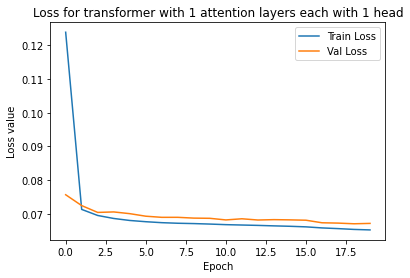

In [ ]:
plt.plot(range(epochs), train_losses_1_1, label="Train Loss")
plt.plot(range(epochs), val_losses_1_1, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss value")
plt.legend()
plt.title("Loss for transformer with 1 attention layers each with 1 head")
plt.show()

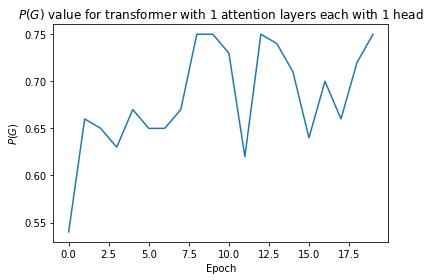

In [ ]:
plt.plot(range(epochs), correct_probs_1_1)
plt.xlabel("Epoch")
plt.ylabel("$P(G)$")
plt.title("$P(G)$ value for transformer with 1 attention layers each with 1 head")
plt.show()

In [ ]:
print(f"Final train loss: {train_losses_1_1[-1]}; Final val loss: {val_losses_1_1[-1]}; Final val P(G): {correct_probs_1_1[-1]}")

Final train loss: 0.0652078241109848; Final val loss: 0.06714339554309845; Final val P(G): 0.75


###### Final Evaluation

In [ ]:
prefixes = dyck2_dataset[:30][0][:, :1].to('cuda:0')
generated_tensor = transformer_model_1_1.generate(prefixes, num_new_tokens=127)

print('\n'.join(dyck2_dataset.decode_tensor(generated_tensor)))

([([[()]])])                                                                                                                    
[[[]]]                                                                                                                          
(())                                                                                                                            
()                                                                                                                              
([((((()))])))                                                                                                                  
()                                                                                                                              
(())                                                                                                                            
([])                                                                                             

In [ ]:
transformer_model_1_1.eval();

In [ ]:
with torch.no_grad():
  print(f"Test loss:{cross_entropy_for(transformer_model_1_1, dyck2_test).cpu().detach().numpy()}")

Test loss:0.06226879358291626


In [ ]:
proba_correct = monte_carlo_probability_generated_is_correct(transformer_model_1_1, max_n_samples=1000, max_n_new_tokens=127)
print(f"Test P(G) = {proba_correct[0]}")

Test P(G) = 0.782


##### Wider: 1 layer with 2 heads

Exactly the same setting.

Results:
- Test loss $0.0598$
- Test $P(G)=0.83$

###### Training

In [ ]:
# Training
vocab_size = dyck2_dataset.get_vocab_size()  # ()[]<space>
n_embed = 256  # the same chosen by Weiss et al. for their experiments
n_hid = 512 # the same chosen by Weiss et al.
max_n_block = 128
n_attn_layer = 1
device = 'cuda:0'
batch_size = 256
learning_rate = 1e-4
n_head = 2
epochs=20

# train

transformer_model_1_2 = ShallowTransformer(n_attn_layer, n_head, vocab_size, n_embed, max_n_block, n_hid, device)
transformer_model_1_2

ShallowTransformer(
  (embedding): Embedding(5, 256)
  (positional): Embedding(128, 256)
  (linear_read_out): Linear(in_features=256, out_features=5, bias=True)
  (attn_layers): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=512, out_features=256, bias=True)
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
    (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  )
)

In [ ]:
train_losses_1_2, val_losses_1_2, correct_probs_1_2 = transformer_train(transformer_model_1_2, dyck2_dataset, dyck2_validation, batch_size, learning_rate, epochs)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

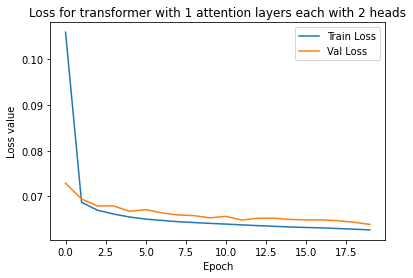

In [ ]:
plt.plot(range(epochs), train_losses_1_2, label="Train Loss")
plt.plot(range(epochs), val_losses_1_2, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss value")
plt.legend()
plt.title("Loss for transformer with 1 attention layers each with 2 heads")
plt.show()

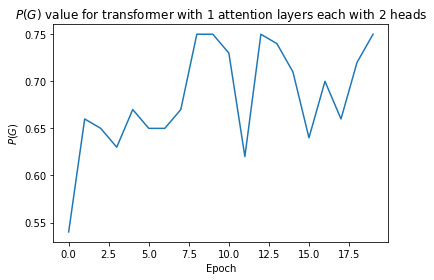

In [ ]:
# TODO Correct this graph
plt.plot(range(epochs), correct_probs_1_2)
plt.xlabel("Epoch")
plt.ylabel("$P(G)$")
plt.title("$P(G)$ value for transformer with 1 attention layers each with 2 heads")
plt.show()

In [ ]:
print(f"Final train loss: {train_losses_1_2[-1]}; Final val loss: {val_losses_1_2[-1]}; Final val P(G): {correct_probs_1_2[-1]}")

Final train loss: 0.06267338991165161; Final val loss: 0.06387662142515182; Final val P(G): 0.8


###### Final Eval

In [ ]:
prefixes = dyck2_dataset[:30][0][:, :1].to('cuda:0')
generated_tensor = transformer_model_1_1.generate(prefixes, num_new_tokens=127)

print('\n'.join(dyck2_dataset.decode_tensor(generated_tensor)))

(([([()])]))((((([])))))))                                                                                                      
[]                                                                                                                              
(([]))                                                                                                                          
([]([(()])])()                                                                                                                  
([()])                                                                                                                          
()                                                                                                                              
((()))                                                                                                                          
([])                                                                                             

In [ ]:
# Eval

transformer_model_1_2.eval();
with torch.no_grad():
  print(f"Test loss:{cross_entropy_for(transformer_model_1_2, dyck2_test).cpu().detach().numpy()}")
proba_correct = monte_carlo_probability_generated_is_correct(transformer_model_1_2, max_n_samples=1000, max_n_new_tokens=127)
print(f"Test P(G) = {proba_correct[0]}")

Test loss:0.059851933270692825
Test P(G) = 0.835


##### Deeper: 2 layer with 1 head

Exactly the same setting.

Results:
- Test loss: $0.05661919713020325$
- Test $P(G) = 0.892$

###### Training

In [ ]:
# Training
vocab_size = dyck2_dataset.get_vocab_size()  # ()[]<space>
n_embed = 256  # the same chosen by Weiss et al. for their experiments
n_hid = 512 # the same chosen by Weiss et al.
max_n_block = 128
n_attn_layer = 2
device = 'cuda:0'
batch_size = 256
learning_rate = 1e-4
n_head = 1
epochs=20

# train

transformer_model_2_1 = ShallowTransformer(n_attn_layer, n_head, vocab_size, n_embed, max_n_block, n_hid, device)
transformer_model_2_1

ShallowTransformer(
  (embedding): Embedding(5, 256)
  (positional): Embedding(128, 256)
  (linear_read_out): Linear(in_features=256, out_features=5, bias=True)
  (attn_layers): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=512, out_features=256, bias=True)
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
      (1): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256

In [ ]:
train_losses_2_1, val_losses_2_1, correct_probs_2_1 = transformer_train(transformer_model_2_1, dyck2_dataset, dyck2_validation, batch_size, learning_rate, epochs)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

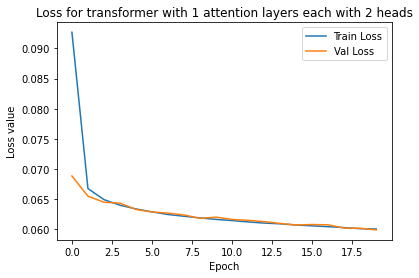

In [ ]:
plt.plot(range(epochs), train_losses_2_1, label="Train Loss")
plt.plot(range(epochs), val_losses_2_1, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss value")
plt.legend()
plt.title("Loss for transformer with 1 attention layers each with 2 heads")
plt.show()

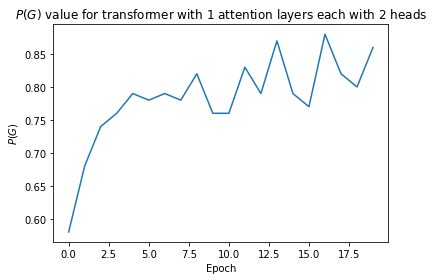

In [ ]:
plt.plot(range(epochs), correct_probs_2_1)
plt.xlabel("Epoch")
plt.ylabel("$P(G)$")
plt.title("$P(G)$ value for transformer with 1 attention layers each with 2 heads")
plt.show()

In [ ]:
print(f"Final train loss: {train_losses_2_1[-1]}; Final val loss: {val_losses_2_1[-1]}; Final val P(G): {correct_probs_2_1[-1]}")

Final train loss: 0.06007738783955574; Final val loss: 0.05992652848362923; Final val P(G): 0.86


###### Final Eval

In [ ]:
# Eval

transformer_model_2_1.eval();
with torch.no_grad():
  print(f"Test loss:{cross_entropy_for(transformer_model_2_1, dyck2_test).cpu().detach().numpy()}")
proba_correct = monte_carlo_probability_generated_is_correct(transformer_model_2_1, max_n_samples=1000, max_n_new_tokens=127)
print(f"Test P(G) = {proba_correct[0]}")

Test loss:0.05661919713020325
Test P(G) = 0.892


In [ ]:
prefixes = dyck2_dataset[:30][0][:, :1].to('cuda:0')
generated_tensor = transformer_model_2_1.generate(prefixes, num_new_tokens=127)

print('\n'.join(dyck2_dataset.decode_tensor(generated_tensor)))

([])                                                                                                                            
[([[]])][[[[[[([])]]]])]                                                                                                        
(())                                                                                                                            
[([[[]][([()])]]]]                                                                                                              
((([([])])))                                                                                                                    
[(((())))]                                                                                                                      
((([[]])))[]()                                                                                                                  
[((([])))]                                                                                       

##### Deeper: 3 layers 1 head

Setup:
- same dataset of size 100000 for training, 1000 for validation and 1000 for testing.
- Deeper, 3 attention layers each with 1 head.
- Train for 20 epochs with batch size 256 and LR of 1e-4.

Results: Got a final test $P(G)=0.973$ and test loss of $0.0545$.

The success here is a bit expected because as per the reasoning above, it was expected that this task be about the same as that for Dyck2-PTF, so the 3 layer 1 head transformer succeeding is unsurprising.

###### Training

In [ ]:
# SETUP

vocab_size = dyck2_dataset.get_vocab_size()  # ()[]<space>
n_embed = 256  # the same chosen by Weiss et al. for their experiments
max_n_block = 128
n_attn_layer = 3
device = 'cuda:0'
batch_size = 256
learning_rate = 1e-4
n_head = 1
epochs=20
n_hid=512

# train

transformer_model_3_1 = ShallowTransformer(n_attn_layer, n_head, vocab_size, n_embed, max_n_block, n_hid, device)
transformer_model_3_1

ShallowTransformer(
  (embedding): Embedding(5, 256)
  (positional): Embedding(128, 256)
  (linear_read_out): Linear(in_features=256, out_features=5, bias=True)
  (attn_layers): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=512, out_features=256, bias=True)
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
      (1): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256

In [ ]:
train_losses_3_1, val_losses_3_1, correct_probs_3_1 = transformer_train(transformer_model_3_1, dyck2_dataset, dyck2_validation, batch_size, learning_rate, epochs)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

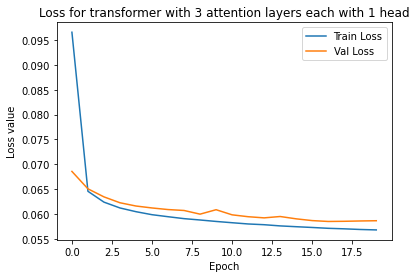

In [ ]:
plt.plot(range(epochs), train_losses_3_1, label="Train Loss")
plt.plot(range(epochs), val_losses_3_1, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss value")
plt.legend()
plt.title("Loss for transformer with 3 attention layers each with 1 head")
plt.show()

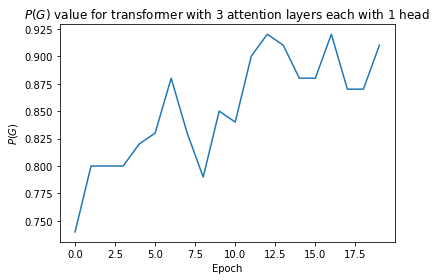

In [ ]:
plt.plot(range(epochs), correct_probs_3_1)
plt.xlabel("Epoch")
plt.ylabel("$P(G)$")
plt.title("$P(G)$ value for transformer with 3 attention layers each with 1 head")
plt.show()

In [ ]:
print(f"Final train loss: {train_losses_3_1[-1]}; Final val loss: {val_losses_3_1[-1]}; Final val P(G): {correct_probs_3_1[-1]}")

Final train loss: 0.05682332068681717; Final val loss: 0.058669302612543106; Final val P(G): 0.91


###### Final evaluation

We perform our final result reporting where we turn dropout off.

In [ ]:
transformer_model_3_1.eval()

ShallowTransformer(
  (embedding): Embedding(5, 256)
  (positional): Embedding(128, 256)
  (linear_read_out): Linear(in_features=256, out_features=5, bias=True)
  (attn_layers): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=512, out_features=256, bias=True)
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
      (1): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256

In [ ]:
prefixes = dyck2_dataset[:10][0][:, :1].to('cuda:0')
generated_tensor = transformer_model_3_1.generate(prefixes, num_new_tokens=127)

print('\n'.join(dyck2_dataset.decode_tensor(generated_tensor)))

([[()]])                                                                                                                        
[[([()]((())))]]                                                                                                                
()                                                                                                                              
(())                                                                                                                            
(([]))                                                                                                                          
(([]))                                                                                                                          
(([[(([]))]]))                                                                                                                  
()                                                                                               

In [ ]:
with torch.no_grad():
  print(f"Test loss:{cross_entropy_for(transformer_model_3_1, dyck2_test).cpu().detach().numpy()}")

Test loss:0.05480443686246872


In [ ]:
proba_correct = monte_carlo_probability_generated_is_correct(transformer_model_3_1, max_n_samples=1000, max_n_new_tokens=127)
print(f"Test P(G) = {proba_correct[0]}")

Test P(G) = 0.957


##### Deeper & Wider: 3 layers with 2 heads

Exactly the same setting.

Results:
- Test loss $0.054$
- Test $P(G)=0.982$


###### Training

In [ ]:
# SETUP

vocab_size = dyck2_dataset.get_vocab_size()  # ()[]<space>
n_embed = 256  # the same chosen by Weiss et al. for their experiments
max_n_block = 128
n_attn_layer = 3
device = 'cuda:0'
batch_size = 256
learning_rate = 1e-4
n_head = 2
epochs=20
n_hid=512

# train

transformer_model_3_2 = ShallowTransformer(n_attn_layer, n_head, vocab_size, n_embed, max_n_block, n_hid, device)
transformer_model_3_2

ShallowTransformer(
  (embedding): Embedding(5, 256)
  (positional): Embedding(128, 256)
  (linear_read_out): Linear(in_features=256, out_features=5, bias=True)
  (attn_layers): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=512, out_features=256, bias=True)
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
      (1): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256

In [ ]:
train_losses_3_2, val_losses_3_2, correct_probs_3_2 = transformer_train(transformer_model_3_2, dyck2_dataset, dyck2_validation, batch_size, learning_rate, epochs)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

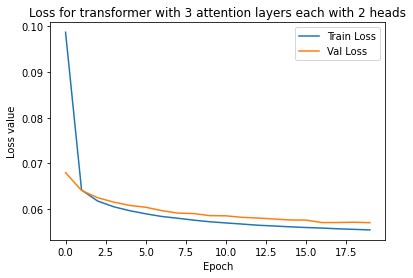

In [ ]:
plt.plot(range(epochs), train_losses_3_2, label="Train Loss")
plt.plot(range(epochs), val_losses_3_2, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss value")
plt.legend()
plt.title("Loss for transformer with 3 attention layers each with 2 heads")
plt.show()

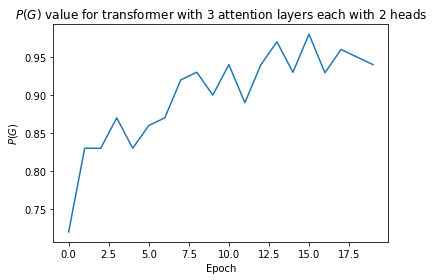

In [ ]:
plt.plot(range(epochs), correct_probs_3_2)
plt.xlabel("Epoch")
plt.ylabel("$P(G)$")
plt.title("$P(G)$ value for transformer with 3 attention layers each with 2 heads")
plt.show()

In [ ]:
print(f"Final train loss: {train_losses_3_2[-1]}; Final val loss: {val_losses_3_2[-1]}; Final val P(G): {correct_probs_3_2[-1]}")

Final train loss: 0.055464401841163635; Final val loss: 0.05704459920525551; Final val P(G): 0.94


###### Final Eval

In [ ]:
transformer_model_3_2.eval()

ShallowTransformer(
  (embedding): Embedding(5, 256)
  (positional): Embedding(128, 256)
  (linear_read_out): Linear(in_features=256, out_features=5, bias=True)
  (attn_layers): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=512, out_features=256, bias=True)
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
      (1): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256

In [ ]:
prefixes = dyck2_dataset[:10][0][:, :1].to('cuda:0')
generated_tensor = transformer_model_3_2.generate(prefixes, num_new_tokens=127)

print('\n'.join(dyck2_dataset.decode_tensor(generated_tensor)))

([])                                                                                                                            
[([])]                                                                                                                          
([([()])])[([[[([[[[((([])))]]]])]]])]                                                                                          
(([]))                                                                                                                          
()()                                                                                                                            
([()[((([[()]])))]])                                                                                                            
(([[[()]]][((()))([[]])][]))                                                                                                    
()()()                                                                                           

In [ ]:
with torch.no_grad():
  print(f"Test loss:{cross_entropy_for(transformer_model_3_2, dyck2_test).cpu().detach().numpy()}")

Test loss:0.054041825234889984


In [ ]:
proba_correct = monte_carlo_probability_generated_is_correct(transformer_model_3_2, max_n_samples=1000, max_n_new_tokens=127)
print(f"Test P(G) = {proba_correct[0]}")

Test P(G) = 0.982


#### Interpretation

*Evaluate the model, and contrast with the Markov model.*

Compared to the Markov model, any of our transformers performs better, even the one with only one head and one layer. The transformers successfully learn to solve the task and seem to be able to remember information from previous tokens in the sequence thanks to causal attention. In contrast, the Markov model can only work from the previous token, respecting the Markov memorilessness assumption. This does imply that there is no way a Markov Model can even express the property of bracket matching. In fact, this is not surprising. Markov Models are probabilistic finite automata, which by definition can only recognise Level 3 (regular) languages, which are proven not to be able to do bracket-matching.


|      | Test Loss | Test P(G) |
|------|-----------|-----------|
| Markov | 0.0898    | 0.0843     |
| 1L1H | 0.062     | 0.782     |
| 1L2H | 0.0598    | 0.83      |
| 2L1H | 0.566     | 0.892     |
| 3L1H | 0.0545    | 0.973     |
| 3L2H | 0.054     | 0.982     |

Amongst the trained transformers, in general, we observe that both adding heads and adding layers increase the performance (measured by the loss and the probability of generating valid strings), as shown in the table below.

As per our expectations given what Weiss et al.'s paper seems to suggest, the model reaches a very high accuracy at 3 layers 1 head, and adding heads after that only give marginal improvement. We might even say that the 3L1H model seems to solve the task pretty well.

However, we must also observe that the kinds of outputs that the transformers generated seem to correspond to only a subset of possible valid strings, which reflects the distribution of the training data, so we might actually be overfitting on our datasets, and hence on our PCFG.



#### Code used to free memory

In [ ]:
import gc

# transformer_model_1_2.cpu()
# del transformer_model_1_2
gc.collect()
torch.cuda.empty_cache()

## Question D.3: Think like a Transformer - Palindromes

*6 marks*

A palindrome is a string which is the same as its reverse. Using two tokens `a` and `b`, the sequence `aabbaabaabbaa` is a palindrome, but `aaabaa` is not.

*Palindrome tagging:* Given an input sequence, we would like to output a binary sequence of the same length. The output at position $t$ should be `1` if the input sequence up to position $t$ is a palindrome, and `0` otherwise. For example, for the input `aabbaabaabbaa` we would like to generate the output `11000100000001` thus tagging the palindromes `a`, `aa`, `aabbaa` and `aabbaabaabbaa`.


1. If you were a Transformer, how would you solve the palindrome tagging task? How many layers do you think are needed? Provide either a high level description of what each layer does (what attention pattern and token transformations are needed), or alterntively, provide your answer as [RASP](https://arxiv.org/abs/2106.06981) code.
1. Create a dataset for the palindrome tagging task. Notice that palindromes are a CFG so you can use the `PCFGDataset` as a starting point. Instead of next token prediction, you have to generate the target `0`s and `1`s.
1. Train a transformer for the task with size inspired by your imagined solution.
1. Extract the transformer's activation pattern on a test input. Tip: you can use `register_forward_hook` to call a function every time a module is evaluated. It may help to look inside the source code of the `MultiheadAttention` module to see how you can recreate the activation map. Do the activation maps look like what you've expected?


**Updated version**

Therefore, please interpret that exercise as follows:

* provide an analysis of a simpler problem, such as determining only if the whole sequence is a palindrome. You may make additional assumptions to make the problem solvable - just be clear about these assumptions and why you made them.
* include a discussion why tagging each prefix as a palindrome is more difficult, and what the implications of this added difficulty are
* when training a model, you may train it on the simpler task, or you can check if it can nevertheless solve the more difficult task

### Answer D.3

Please add your solutions in code and text cells below.

##### Initial analysis of the problem

To simplify the problem, we consider the problem of determining whether a sequence of `a`s and `b`s is a palindrome, padded with spaces as appropriate to 32 tokens. We define that all string that is a palindrome (modulo the remainder) should give all-1 output, otherwise all-0s. E.g. "madam    " should give `"1"*32` and "hello" should give `"0"*32`, regadless of the padding.

Then as a transformer here's one possible thing I could do:

```python
# id just returns identity
id = select(indices, indices, ==);
# length_without_padding computes the length without the padding as predefined
padding = " ";
length_without_padding = 1/ aggregate(select(tokens, padding, !=),
                                      indicator(indices==0));
# flip would reverse the string up to index length-1 and apply identity to the rest
flip = select(indices, length_without_padding-indices-1, ==)
    or (select(indices, length_without_padding, >=)
        and id);
# Reverse reverses the string not including the padding.
reverse = aggregate(flip, tokens);
#
eq_rev = indicator(tokens == reverse);
# This gives the floor of a value
def floor(x) {return 1 if x == 1 else 0;}
# This gives all 1s if we have a palindrome else all 0s.                                             
palindrome_decision = floor(aggregate(select(1, 1, ==), eq_rev));
```

Note here that the padding is handled elegantly without adding any complexity in terms of width or depth of the resulting network by just applying identity instead of reverse to it, and returning 1 at the `palindrome` sop for the padding would mean that the final step of checking whether the list returned is all 1s won't be affected.

As `length_without_padding` takes 1L1H, reverse takes one more 1-head layer, and then the two aggregations I do further take 2 more 1-head layers, I expect this to work with a 3L1H transformer. Let's try to implement this.

In the implementation, notice that I added an "output_vocab_size" param. This is here because I'm essentially using the linear readout layer as a means of reading out values in {0,1} instead of ones from the vocabulary {'a', 'b', ' '}.

##### Definitions


In [ ]:
palindrome_grammar = PCFG.fromstring("""
S -> "a" S "a" [0.42] | "b" S "b" [0.42] | "a" [0.04] | "b" [0.04] | "aa" [0.04] | "bb" [0.04]
""")

non_palindrome_grammar = PCFG.fromstring("""
S ->  S "a" [0.20] | S "b" [0.20] | Va [0.20] | Vb [0.20] | "a" [0.10] | "b" [0.10]
Va ->  Va "a" [0.70] | Va "b" [0.20] | S [0.10]
Vb ->  Vb "a" [0.20] | Vb "b" [0.70] | S [0.10]
""")

In [ ]:
import torch
from pcfg import PCFG
from torch.utils.data import TensorDataset
from torch.nn.functional import pad
from torchtext.vocab import build_vocab_from_iterator
from torchtext.functional import to_tensor, truncate
from typing import Tuple


class PalindromePCFGDataset(TensorDataset):
    tensors: Tuple[torch.Tensor, ...]

    def __init__(self, palindrome_grammar: PCFG, non_palindrome_grammar: PCFG, n_samples: int = 1024, seqlength: int = 128, padchar: str = ' ') -> None:
        # Generate sentences -- trick for balanced dataset
        sentences =[sentence.replace(' ', '') for sentence in palindrome_grammar.generate(n_samples//3)] \
                  + [sentence.replace(' ', '') for sentence in non_palindrome_grammar.generate(n_samples//3*2)]
        # Create Labels
        labels = []
        for i, s in enumerate(sentences):
          s = s[:seqlength]
          if s[::-1] == s:
            labels.append(torch.ones(seqlength))
          else:
            labels.append(torch.zeros(seqlength))

        labels = torch.stack(labels)

        assert labels.size(0) == len(sentences)
        sentences = np.array(sentences)

        # shuffle them
        permutation = np.random.permutation(np.arange(len(sentences)))
        sentences = sentences[permutation]
        labels = labels[permutation]

        vocab = build_vocab_from_iterator(''.join(sentences) + padchar)
        self.vocab = vocab

        indices = [vocab([c for c in sentence]) for sentence in sentences]
        T = to_tensor(truncate(indices, max_seq_len=seqlength + 1), padding_value=vocab[padchar])
        B, L = T.shape
        T = pad(T, (0, seqlength + 1 - L), 'constant', vocab[padchar])
        X = T[:, :-1]
        # We need this because otherwise it gives nll_loss_forward_reduce_cuda_kernel_2d_index not implemented error
        Y = labels.type(torch.LongTensor)
        print(X.shape)
        print(Y.shape)
        assert X.shape == Y.shape
        self.tensors = (X, Y.contiguous())

    def __getitem__(self, index: int):
        return tuple(tensor[index] for tensor in self.tensors)

    def __len__(self):
        return self.tensors[0].size(0)

    def decode_tensor(self, t: torch.Tensor):
        """Decodes a tensor of integers into strings. Useful for printing model
        generations."""
        itos = self.vocab.get_itos()
        return [''.join([itos[i] for i in sequence]) for sequence in t.tolist()]

    def get_vocab_size(self):
        """Returns size of vocabulary."""
        return len(self.vocab)

    def head(self, n: int):
        """Prints the string representation of the first n datapoints."""
        print('\n'.join(self.decode_tensor(self[:n][0])))

In [ ]:
from tqdm.notebook import tqdm
from torch.optim import Adam
from torch.utils.data import DataLoader

from torch.nn.functional import softmax

def palindrome_transformer_train(transformer_model,
                                 train_dataset,
                                 val_dataset,
                                 batch_size,
                                 learning_rate,
                                 epochs):

    train_dataset.tensors = tuple(tensor.to('cuda:0') for tensor in train_dataset.tensors)
    train_loader = DataLoader(train_dataset, batch_size)
    val_dataset.tensors = tuple(tensor.to('cuda:0') for tensor in val_dataset.tensors)
    val_loader = DataLoader(val_dataset, batch_size)

    optimizer = Adam(transformer_model.parameters(), lr=learning_rate)
    train_losses = []
    val_losses = []
    with tqdm(range(epochs)) as t_global:
        for _ in t_global:
            losses = []
            with tqdm(train_loader) as t_train_loader:
              for (x, y) in (t_train_loader):
                  optimizer.zero_grad()
                  logits, loss = transformer_model(x, y)
                  loss.backward()
                  optimizer.step()
                  with torch.no_grad():
                      losses += [loss.cpu().detach().numpy()]
            # Accumulate validation data
            with torch.no_grad():
                mean_train_loss = np.mean(losses)
                train_losses.append(mean_train_loss)
                val_losses_iter = []
                accuracy_acc = 0
                for (x, y) in val_loader:
                  val_losses_iter += [transformer_model(x, y)[1].cpu().detach().numpy()]
                val_loss = np.mean(val_losses_iter)
                val_losses.append(val_loss)
                t_global.set_postfix(
                     {'Train loss': mean_train_loss, 'Val loss': val_loss})
    return train_losses, val_losses

In [ ]:
def accuracy(dataset, model):
  s = 0
  cnt = 0
  for (x, y) in dataset:
    logits, _ = model(x.to('cuda:0').unsqueeze(0), None)
    p = softmax(logits, dim=-1).squeeze()
    if all(p[:, 1] > p[:, 0]) and y[0] == 1:
      s += 1
    elif all(p[:, 1] < p[:, 0]) and y[0] == 0:
      s += 1
    cnt += 1
  return s/cnt

def accuracy_by_majority_voting(dataset, model):
  s = 0
  cnt = 0
  for (x, y) in dataset:
    logits, _ = model(x.to('cuda:0').unsqueeze(0), None)
    p = softmax(logits, dim=-1).squeeze()
    if torch.mean((p[:, 1] > p[:, 0]).type(torch.float)) > 0.5 and y[0] == 1:
      s += 1
    elif torch.mean((p[:, 1] > p[:, 0]).type(torch.float)) < 0.5 and y[0] == 0:
      s += 1
    cnt += 1
  return s/(cnt)

##### Training

Note that I chose to generate samples from two different grammars, one for generating palindrome strings and one for generating non-palindrome strings. This is because we are effectively doing binary classification, and so we want to make the dataset balanced and not to introduce any bias to the model. This choice is discussed further in the attention-map-interpretation section.

In [ ]:
palindrome_dataset = PalindromePCFGDataset(palindrome_grammar, non_palindrome_grammar, 1000000, seqlength=32)
palindrome_validation = PalindromePCFGDataset(palindrome_grammar, non_palindrome_grammar, 1000, seqlength=32)
palindrome_test = PalindromePCFGDataset(palindrome_grammar, non_palindrome_grammar, 1000, seqlength=32)


torch.Size([999999, 32])
torch.Size([999999, 32])
torch.Size([999, 32])
torch.Size([999, 32])
torch.Size([999, 32])
torch.Size([999, 32])


In [ ]:
# This calculates how many elements in the dataset are palindromes -- should be around 1/2
sum(palindrome_dataset[:][1][:, 0])

tensor(520409, device='cuda:0')

In [ ]:
# Define transformer
# defn
vocab_size = palindrome_dataset.get_vocab_size()  # ()[]<space>
n_embed = 256  # the same chosen by Weiss et al. for their experiments
n_hid = 512 # the same chosen by Weiss et al.
max_n_block = 32 # Scale down
n_attn_layer = 3
output_vocab_size = 2
n_head = 1
causal_mask = False
# training
device = 'cuda:0'
batch_size = 256
learning_rate = 1e-4
epochs = 10

# train

transformer_model_palindrome = ShallowTransformer(n_attn_layer, n_head, vocab_size, n_embed, max_n_block, n_hid, device, causal_mask, output_vocab_size)
transformer_model_palindrome

ShallowTransformer(
  (embedding): Embedding(3, 256)
  (positional): Embedding(32, 256)
  (linear_read_out): Linear(in_features=256, out_features=2, bias=True)
  (attn_layers): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=512, out_features=256, bias=True)
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
      (1): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256,

In [ ]:
palindrome_train_losses, palindrome_val_losses = palindrome_transformer_train(transformer_model_palindrome,
                                                                              palindrome_dataset,
                                                                              palindrome_validation,
                                                                              batch_size,
                                                                              learning_rate,
                                                                              epochs)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3907 [00:00<?, ?it/s]

  0%|          | 0/3907 [00:00<?, ?it/s]

  0%|          | 0/3907 [00:00<?, ?it/s]

  0%|          | 0/3907 [00:00<?, ?it/s]

  0%|          | 0/3907 [00:00<?, ?it/s]

  0%|          | 0/3907 [00:00<?, ?it/s]

  0%|          | 0/3907 [00:00<?, ?it/s]

  0%|          | 0/3907 [00:00<?, ?it/s]

  0%|          | 0/3907 [00:00<?, ?it/s]

  0%|          | 0/3907 [00:00<?, ?it/s]

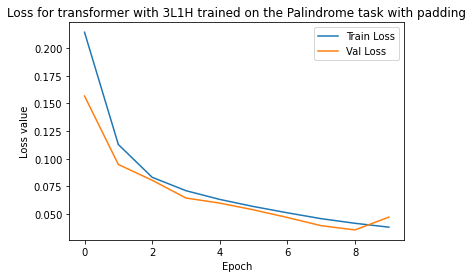

In [ ]:
plt.plot(range(epochs), palindrome_train_losses, label="Train Loss")
plt.plot(range(epochs), palindrome_val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss value")
plt.legend()
plt.title("Loss for transformer with 3L1H trained on the Palindrome task with padding")
plt.show()

In [ ]:
transformer_model_palindrome.train();
print(f"val accuracy: {accuracy(palindrome_validation, transformer_model_palindrome)}")
print(f"val accuracy by majority vote: {accuracy_by_majority_voting(palindrome_validation, transformer_model_palindrome)}")

val accuracy: 0.950950950950951
val accuracy by majority vote: 0.98998998998999


In [ ]:
print(f"Final train loss: {palindrome_train_losses[-1]}; Final val loss: {palindrome_val_losses[-1]}")

Final train loss: 0.038056354969739914; Final val loss: 0.0471431240439415


##### Testing

If we calculate accuracy as the average number of *completely* correct outputs (i.e. all 32 of the output tokens must be 0 or 1 accordingly), we get an accuracy of 99.3%; if we calculate accuracy where correctly classifying means winning a majority vote amongst the 128 output tokens, we get a 99.4% accuracy. As expected, our transformer did pretty well.

In [ ]:
# We choose example "abbabba".
def encode_helper(s):
  if len(s) > 32: return None
  return torch.tensor(palindrome_dataset.vocab(list(s + (32 - len(s)) * ' ')))

def predict(s, model):
  with torch.no_grad():
    logits, _ = model(encode_helper(s).unsqueeze(0).to('cuda:0'), None)
    p = softmax(logits, -1)
    return (p[0, :, 1] > p[0, :, 0]).type(torch.int), p

In [ ]:
transformer_model_palindrome.eval();

In [ ]:

# Test loss
with torch.no_grad():
  print(f"Test loss:{cross_entropy_for(transformer_model_palindrome, palindrome_test).cpu().detach().numpy()}")

Test loss:0.017048312351107597


In [ ]:
print(f"Test Accuracy: {accuracy(palindrome_test, transformer_model_palindrome)}")
print(f"Test Accuracy by majority voting: {accuracy_by_majority_voting(palindrome_test, transformer_model_palindrome)}")

Test Accuracy: 0.992992992992993
Test Accuracy by majority voting: 0.993993993993994


##### Introspecting the activations

Now let's explore whether the activations we got are the ones we expected.

In [ ]:
import copy

model_clone = copy.deepcopy(transformer_model_palindrome)
model_clone

ShallowTransformer(
  (embedding): Embedding(3, 256)
  (positional): Embedding(32, 256)
  (linear_read_out): Linear(in_features=256, out_features=2, bias=True)
  (attn_layers): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=512, out_features=256, bias=True)
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
      (1): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256,

In [ ]:
attn_map = [None, None, None, None]
def get_map(i, module, input, output):
  _, attn_weight_map = module.forward(*input, key_padding_mask=None, need_weights=True, attn_mask=None)
  global attn_map
  attn_map[i] = attn_weight_map.detach().cpu()

In [ ]:
from functools import partial

for i in range(3):
  model_clone.attn_layers.layers[i].self_attn.register_forward_hook(partial(get_map, i))

In [ ]:
import seaborn as sns

def plot_for(s, display_bound=30):
  s_padded_for_visualisation = s + (128-len(s)) * "_"
  model_clone(encode_helper(s).to("cuda:0").unsqueeze(0), None);

  fig, axs = plt.subplots(1, 3, figsize=(20, 4))

  for i in range(3):
    sns.heatmap(attn_map[i][0, :display_bound, :display_bound].cpu().detach(), vmax=1., ax=axs[i], xticklabels=s_padded_for_visualisation[:display_bound], yticklabels=s_padded_for_visualisation[:display_bound])
    axs[i].set_title(f"Attention map at layer {i} head 0")
  fig.suptitle(f"Attention map for {s} up to character {display_bound}")
  plt.show()

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0', dtype=torch.int32)


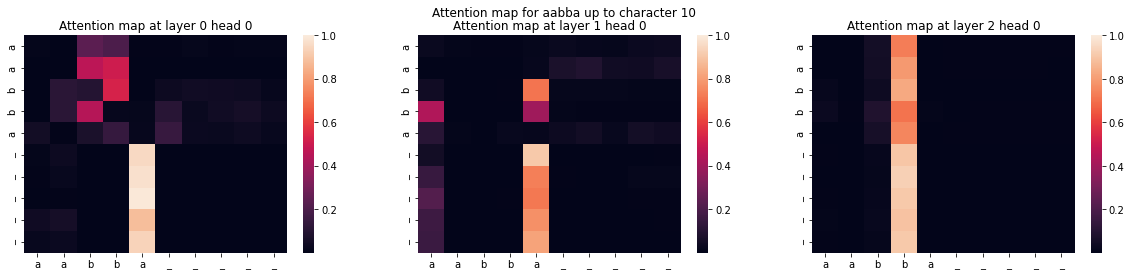

In [ ]:
print(predict("aabba", model_clone)[0])
plot_for("aabba", display_bound=10)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0', dtype=torch.int32)


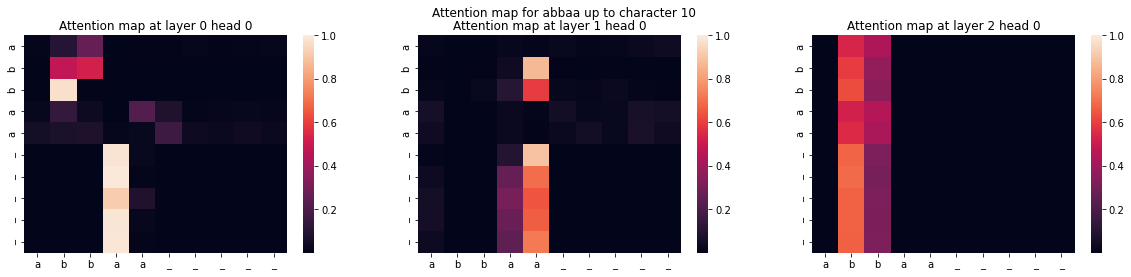

In [ ]:
print(predict("abbaa", model_clone)[0])
plot_for("abbaa", display_bound=10)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0', dtype=torch.int32)


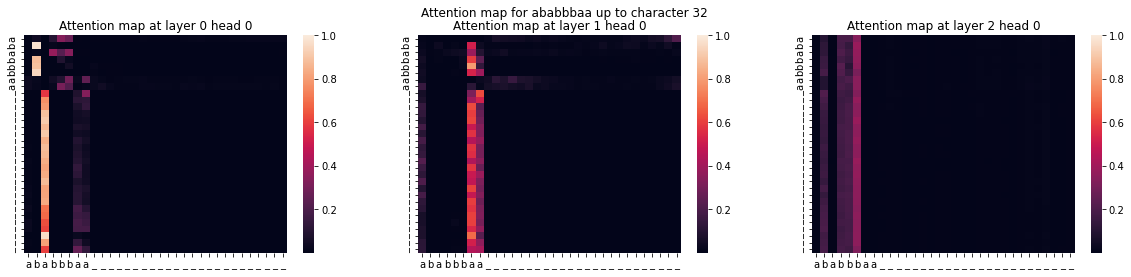

In [ ]:
print(predict("ababbbaa", model_clone)[0])
plot_for("ababbbaa", display_bound=32)

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0', dtype=torch.int32)


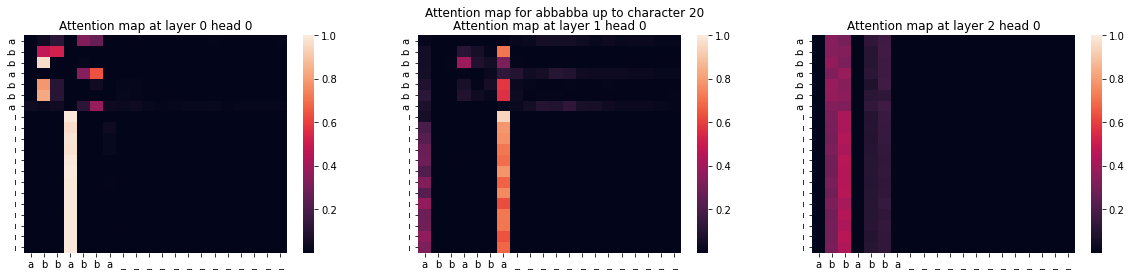

In [ ]:
print(predict("abbabba", model_clone)[0])
plot_for("abbabba", display_bound=20)

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0', dtype=torch.int32)


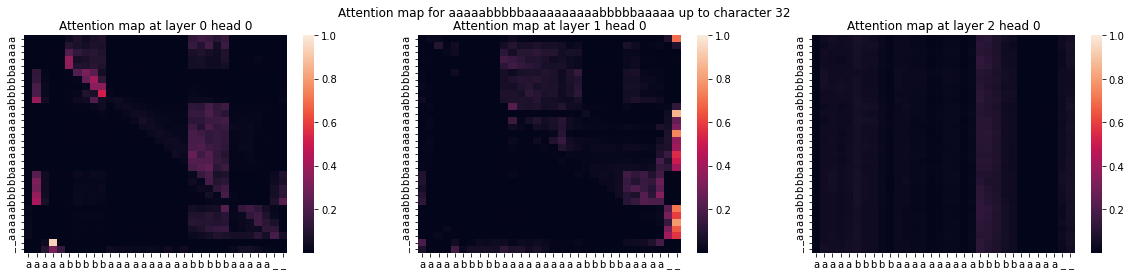

In [ ]:
print(predict("aaaaabbbbbaaaaaaaaaabbbbbaaaaa", model_clone)[0])
plot_for("aaaaabbbbbaaaaaaaaaabbbbbaaaaa", display_bound=32)

These activation patterns don't look like what I expected at all. Taking the example of "abbabba", what I expected should have been the following (apologies for the big images, they are directly inserted to avoid any trace of my identity)
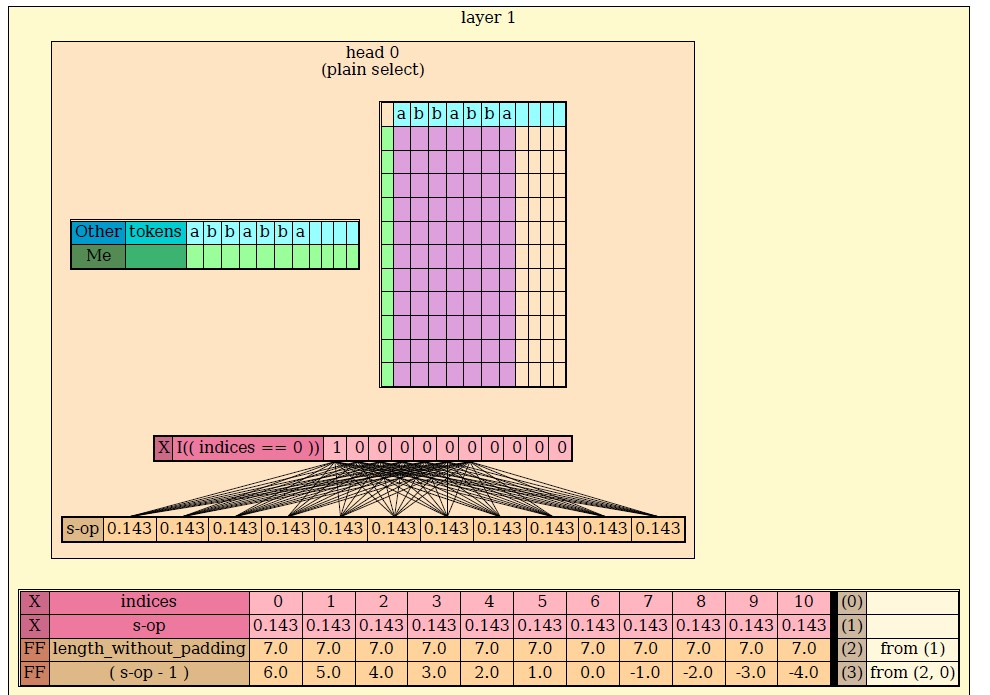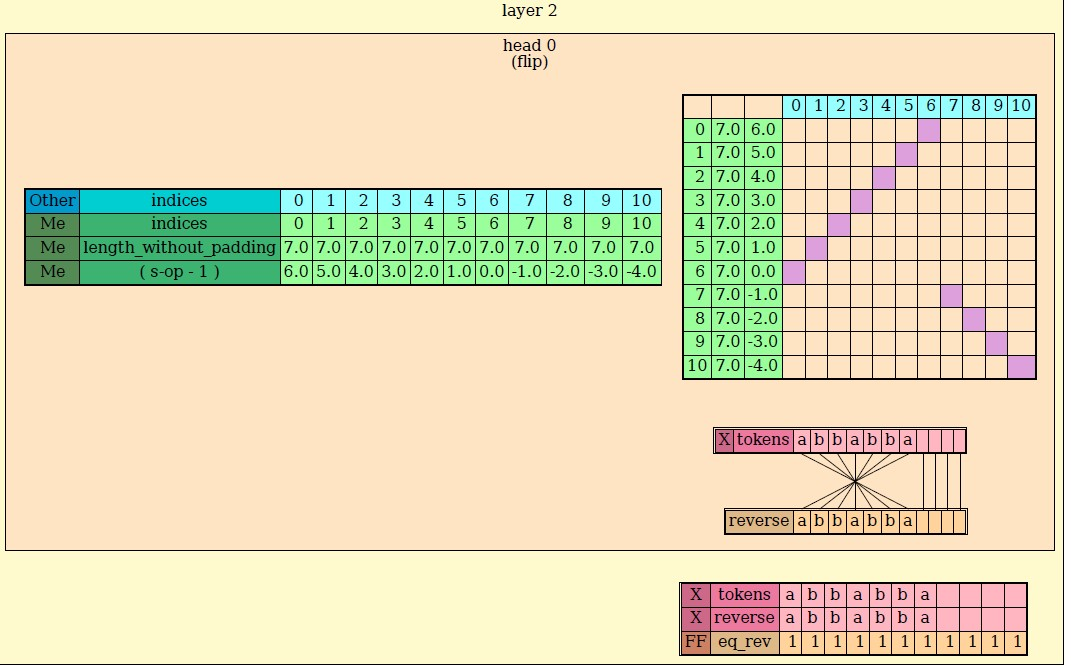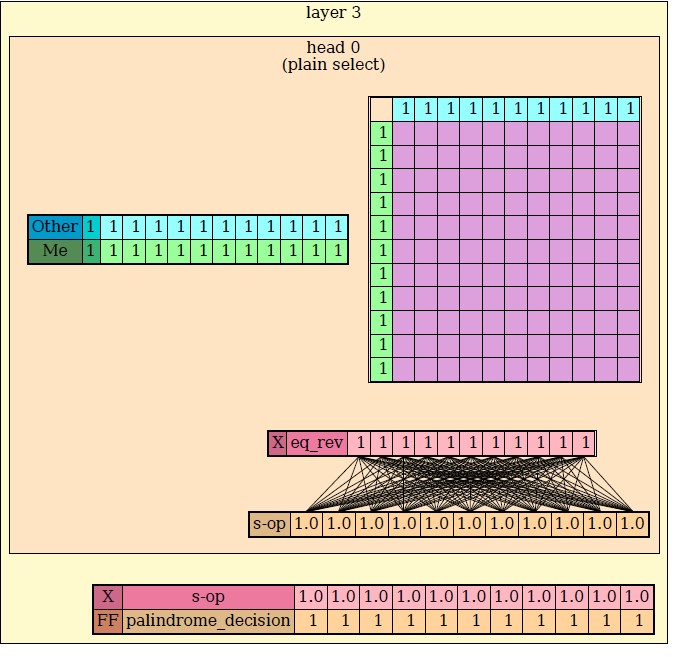



We do get the behaviour of "masking out" the padding in our actual transformer like in layer 1 of the RASP simulated one (btw layer 0 does not have any attention component), but for the rest, I see nothing similar.

There seems to be some explicit "memorisation" of the positions of "a" and "b" tokens on separate layers, but it is unclear what it is actually doing. One thing that is clear is that the model doesn't actually seem to be (at least explicitly) reversing its input and checking for equality.

Further inspection displays the failure modes of my model: strings like `aaaaaabbbbbbaaaaaa` would give output 11111111... without any problem, but if we insert an `a` in the middle so as to break the symmetry to give `aaaaaabbabbbbaaaaaa`, the model seems to still output 11111..., each with high confidence, as shown below.

This might be because the above case is in fact unlikely to be generated by our data generation procedure. Since the model fits so well to our data and performs really well on test data, I hypothesise that the model overfits to the distribution of strings generated by our two different PCFGs, to this hidden structure in the data that is not intrinsic to the palindrome property, but related to the details of the PCFGs themselves.

To make the model actually generalise we probably have to rewrite the data generation procedure, which, due to time constraints, I shall leave as future work.


In [ ]:
predictions, probabilities = predict("aaaaaabbabbbbaaaaaa", transformer_model_palindrome)
predictions, probabilities

(tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0', dtype=torch.int32),
 tensor([[[0.0139, 0.9861],
          [0.0264, 0.9736],
          [0.0183, 0.9817],
          [0.0182, 0.9818],
          [0.0232, 0.9768],
          [0.0212, 0.9788],
          [0.0191, 0.9809],
          [0.0191, 0.9809],
          [0.0240, 0.9760],
          [0.0206, 0.9794],
          [0.0221, 0.9779],
          [0.0225, 0.9775],
          [0.0231, 0.9769],
          [0.0201, 0.9799],
          [0.0187, 0.9813],
          [0.0219, 0.9781],
          [0.0197, 0.9803],
          [0.0216, 0.9784],
          [0.0182, 0.9818],
          [0.0184, 0.9816],
          [0.0209, 0.9791],
          [0.0195, 0.9805],
          [0.0197, 0.9803],
          [0.0184, 0.9816],
          [0.0208, 0.9792],
          [0.0170, 0.9830],
          [0.0172, 0.9828],
          [0.0150, 0.9850],
          [0.0186, 0.9814],
          [0.0188, 0.9812],
        

##### Discussion: Why is Palindrome tagging more difficult


Palindrome tagging is essentially the task of palindrome recognition at every character in the sequence: at each character, we only look at the previous characters and output 1 if they form a palindrome, 0 if not.

This is clearly more difficult than just distinguishing whether the string is a palindrome, because checking that a string is a palindrome does not straightforwardly directly depend on any of its prefixes being a palindrome, and vice versa. In fact, whether a string is a palindrome only really depends on whether the substring starting from the middle of the string, with an equal number of characters on both sides, is a palindrome.

It is clear that unlike the Dyck-k languages (where recognition of a string $s$ clearly depends on the tagging task on $s[:-1]$), the palindrome tagging task does not reflect this property that tagging each prefix is part of recognising a palindrome, so the former is likely much more complex than the latter.

To be able to tag each palindrome prefix, one might need to many more layers/heads. As a mental model of how transformers work, we can take Rasp, which is a special case of a system allowing only maps and reduces (a map reduce language) over a fixed sequence length. Naively, we'd need to reverse every prefix and check whether they are equal, which clearly takes $O(n)$ (so non-constant) heads. Thinking in terms of Rasp, I conjecture that we **cannot** implement this with the selection/aggregation/element-wise operations given in a constant number of layers and heads. However, there might be solutions requiring only a subinear number of attention layers.


# E: Mini-Project

*40 marks*

Please **choose one** of the proposed mini-project questions below. Add as many text and code cells under the heading as you'd like. You may attempt more than one, but we will only mark one: please write below which mini-project you'd like to get marked on:

**I would like my solution for mini-project ___E3___ to be marked.**

## E.1: CNN Loss Landscape.

A loss landscape is a visual representation (2D or 3D) of the relationship between a model's parameters and its loss function calculated a given dataset. It is usually represented as a high-dimensional surface, where the height of the surface at any point represents the value of the loss function for a particular combination of parameter values. By analyzing the shape of this surface, researchers can gain insights into the behavior of machine learning models, and can develop more efficient algorithms for training them.

The loss landscape can be affected by a variety of factors, including the architecture of the model, the choice of optimization algorithm, and even the batch size used during training.




![](https://github.com/pedropgusmao/loss-landscape/raw/master/doc/images/resnet56_noshort_small.jpg)
![](https://github.com/pedropgusmao/loss-landscape/blob/master/doc/images/resnet56_sgd_lr=0.1_bs=128_wd=0.0005/model_300.t7_weights_xignore=biasbn_xnorm=filter_yignore=biasbn_ynorm=filter.h5_%5B-1.0,1.0,51%5Dx%5B-1.0,1.0,51%5D.h5_train_loss_2dcontour.jpg?raw=true)

In this mini-project you will have the opportunity to analyse the effects of training a network using various sets of hyper-paramenter on the final solution and, most importantly, on its vicinity.


#### Loss Landscape Exploration (~20 marks)

In this first part of the mini-project, you will analyse the effects of changing network architecure, training batch size, optimizer, and the use of weight decay for SGD. For this, you will:
* Use the code provided [in this repository](https://github.com/pedropgusmao/loss-landscape) to produce 2D and 3D representations of loss functions for various architectures.
* Compare the various plots (all networks) to the *VGG9* baseline model trained using *Stochastic Gradient Decent*, batch size *128*, learning rate of *0.1*, and *no weight decay* (i.e., the *sgd_lr=0.1_bs=128_wd=0.0_save_epoch=1* model).
* Report your findings and explain the differences you see. We suggest you use the **train_loss_2dcontour.pdf** plots for your analysis as they contain more information.

*Tip: Generating all plots may require a lot of time and compute. Feel free to use the plots that come with the **Pre-trained models** instead to help you save time.*

#### Network Trajectories (~20 marks)
During the second part of your mini-project, you are asked to plot and analyse the trajectory of your network.
* Follow the instructions under the repository's **Plotting the network trajectory** section to generate plots for various sets of hyper-parameters.
* Compare how quickly your models converge and in which directions.
* What can you say about the region where the models converged to?
* Can you relate flatness with generalization?  

Code examples have been forked from the [original code](https://github.com/tomgoldstein/loss-landscape) for the paper *Visualizing the Loss Landscape of Neural Nets, Li, Hao, et al. 2018*. This forking was done by Pedro P.B. Gusmão (pp524@cl.cam.ac.uk) and in addition to contacting Nic and Ferenc questions, especially about this code, feel free to contact him. Relevant parts of the forked repository are identified with the tag **(mini-project)**.


## E.2: Transfer Learning

Throughout the course, you were able to train a few models to solve the task of object classification where each image in a dataset is associated with a single class $c$ from a pre-defined set of classes.</p>

Closely related to this is the problem of object detection, where each image may contain multiple objects at different locations and it is your job to both localise and classify such objects.

Clearly one problem *contains* the other and it is natural to think that solving one (classification) could help solve the other. Instead, it is a bit less obvious whether or not an object detection network trained to detect object from a set of classes $C$ can be slightly modified to detect objects from a different set of classes $D$.

In this project you will learn how to modify a pre-trained network to work on a different set of classes in a process called **Transfer Learning**.  

![](https://upload.wikimedia.org/wikipedia/commons/2/2d/Intersection_over_Union_-_object_detection_bounding_boxes.jpg)

You will start with a [Faster R-CNN](https://pytorch.org/vision/main/models/faster_rcnn.html) detection network, pre-trained to detect objects from the [COCO dataset](https://cocodataset.org/#home) and your task will be to make the network detect traffic signs from the [GTSRB German Traffic sign](https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign) dataset instead in the most efficient way.

*Pro Tip:*
Transfer Learning involves keeping information from the original task that is still relevant to the new task, and retraining the parts that cannot be reused. This can be done by *freezing* weights in early layers, and *fine-tuning* or even retraining later layers. Your job is to use a combination of these to methods and produce a high-preformance detection network with minimal training effort.  

To do this, it is essential that you understand the architecture of you network.The Faster R-CNN is essentially made of three sub-networks:
1. A *backbone* object classification network that will produce feature maps (responsible for extracting feature, from low to high). This can be swapped and is usually based on network trained on a large Image Classification Dataset.
2. A *Region Proposal Network (RPN)* which will generate bounding-boxes with an *objectness* score each.
3. A Classification Layer, that will warp the regions proposed by the RPN and classify them according to our set of classes. This is highly dependent on the task and number of classes being considered.

#### Experimental Exploration (~25 marks)
We'd like you to dig into transfer learning by trying it yourself. Below we provide some directions, but feel free to expand and adapt these.

* Train the Faster R-CNN from scratch using the GTSD dataset.
* Freeze the entire backbone network and train the Classification Layer from scratch on the German Traffic Sign Detection Benchmark dataset.
* Fine-tune the backbone network at different depths (e.g. freeze just the first layer, then just the first three layers, etc...) and retrain the Classifier.
* *BONUS:* Consider replacing and adapting the backbone. Use networks pretrained on different datasets (VOC Pascal, ImageNet), or different architectures.

For each configuration, calculate mean average and precision (mAP) and training times in terms of wall-clock time and number of epochs.

#### Reflection on Experiments (~15 marks)
Consider the following questions:
 * How long did it take to train the detection network from scratch? Does it generalize well?
 * Did freezing the backbone network help speeding up training? Was there a loss in preformance?
 * Which backbone works best? Is it better to have a larger backbone trained on larger datasets or a smaller backbone trained on data that is closer to the target domain?






## E.3: Model compression via Weight Matrix Decomposition

Model compression is the generic name used to refer to techniques applied to model architectures so that they can be more system resource efficient -- especially at inference time. (If you wish to read more about this area feel free to consult this [tutorial](https://arxiv.org/abs/1703.09039), but note it is not needed in this assignment.) In this mini-project, you will have the opportunity to explore one of these methods that involves decomposing a single large weight matrix of an architecture into a series of smaller matrices to reduce memory and compute needs, while still maintaining accuracy levels of the original model.

A popular early approach of this type involved using matrix factorization methods (like SVD) and applying them to layers within an architecture where the weight matrix causes performance bottlenecks for the whole model. In this case a single weight matrix is broken down into two smaller matrices, the product of which approximates the original larger matrix.

This mini-project is comprised by the following following steps and questions below. We ask that you work with a pretrained [AlexNet](https://papers.nips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf) and the ImageNet dataset. We will be using SVD to perform the matrix factorization:

* Applying SVD decomposition to AlexNet's fully-connected (dense) layers *(~10 marks).*
  * Perform SVD on the weight matrix of the first fully-connected layer of AlexNet. The weight matrix of the layer will be decomposed into two matrices ($U$ and $V$ by SVD) *(note, feel free to use a library implementation of SVD)*.
  * Under which conditions will the use of the $U$ and $V$ matrices above, when used in place of the weight matrix, result in parameter savings?
  * Implement a new layer type that you can use to replace the fully-connected layers within AlexNet. This new layer type should replace the single weight matrix in a conventional fully-connected layer with the $U$ and $V$ matrices. Include a parameter in your layer that determines how many singular vectors are used (parameter $k$ within SVD) *(note, you only need to implement the forward-pass of this layer given how we use it next)*.
  * Replace both fully-connected layers within AlexNet with your new layer type developed above. Experiment by varying the values of $k$ and see how this changes the test accuracy of the model *(note, to speed-up experiments only compute accuracy for a 128-example subset of ImageNet test data, also only use $k$ values that result in an overal reduction of parameters in the model)*.
* Implementing the SVD decomposition as two seperate layers *(~20 marks).*
  * Show that the new layer you implemented above, to support the decomposition of weights, can also be viewed (and implemented) as two seperate layers. Provide an illustration to show this is possible, and also provide a new implementation of a layer type to support this *(note, again at this stage only the forward pass of the implementation is required)*.
  * Describe the implications to the per-layer working set memory at inference time (defined during lectures) of implementing weight decomposition as two layers compare to when it is implemented as a single layer?
* Re-training your SVD decompositions *(~10 marks).*
  * Implement the backwards pass of the two-layer approach to supporting SVD-based weight decomposition.
  * Re-train the AlexNet model with both fully-connected layers using this two-layer implementation *(note, you must re-train all model parameters, not just those related to the fully-connected layers)*. Did test accuracy improve? *(please use the 128-example subset of ImageNet used earlier)*. If you observe an improvement discuss why this is the case.
  * Comment on the similarity and design considerations of your modified version of AlexNet to the MobileNet architecture discussed in lectures.
  


## E.4: Investigating Gradient Stabilization

As Ferenc mentioned during his lectures gradient instability is a fundemental barrier to successful training. In this mini-project we will dive into this issue.

Before beginning, construct a version of MobileNetV2 from which you have removed the architectural components that manage the gradient. That is remove from it batch normalization layers and residual connections. We will use this "stripped" version of MobileNetV2 multiple times below (we call it below "stripped MobileNetV2"). You will recall this architecture from the prior assignment.

*As a hint: you will also find it useful to implement a helper function that computes the average gradient at each layer when provided a batch of training examples.*

* Early Training Gradient Stabilization *(~10 marks).*
  * Use the stripped MobileNetV2 described above and begin by initalizing it (rather than using any pretrained weights). Create three versions related to three initialization schemes: (1) all parameters set to a constant; (2) all set as random uniform; (3) all set using Xavier initialization (i.e., use the default PyTorch initialization). (For some background on this topic consult this [paper](https://arxiv.org/abs/1704.08863).)
  * Visualize the gradients generated when training these three networks using one batch of data taken from ImageNet, holding everything else constant. *(note, use the visualization helper function described earlier)*. Briefly comment on the differences you see. Expand your set of experiments by also testing with at least three different constants for the first scheme described (e.g., try using: $0$, $1$, $1000$).
* Mid-Training Gradient Stabilization *(~20 marks).*
  * We will now investigate gradients that are in-use during *mid-training*. These gradients will be available if you take the original MobileNetV2 architecture amd train it for three epochs using ImageNet using all the settings (e.g., initalizer etc.) detailed in the original [paper](https://arxiv.org/abs/1801.04381). Copy the weights of this network to the "stripped" MobileNetV2.  
  * Investigate the role played by the residual connections. Insert the residual connections back to the model, and backpropagate a single batch (ImageNet). Collect and visualize the gradients using your helper function. Comment on what are the effects of inserting the residual connections back to the early, middle, and the final layers of the network.
  * Next, investigate the role played by the batch normalization. Insert the batch normalization layers back to the model, and backpropagate a single batch through the model. Collect and visualize the gradients using your helper function. Comment on what effects does inserting the batch normalization back to the beginning, middle, and the end of the network have. *(note, use the batch normalization in its training mode)*.
  * Compare the effects of the residual connections and the batch normalizations.
* Gradients - Going Beyond Training *(~10 marks).*
  * For this final exploration, revert back to a pretrained MobileNetV2 without any changes to the architecture. In the following steps we will freeze the model's parameters, and propagate gradients into the input.
  * Define a simple loss function that is minimized when the output activation corresponding to one ImageNet class is maximized and all other classes have 0 value. (Let's call this class $C$, you can select any ImageNet class you wish).
  * Given this loss, now identify an input image that would minimize the loss. Perform a test where you initialize an input in four different ways: (1) all zeros; (2) random; (3) image of the class $C$; (4) image not of the class $C$. Compute the gradients of the loss function with respect to the pixels in the input image. *(note, the network parameters are held constant!)* Update the image using these gradients. Repeat gradient computation and update until image stops changing.
  * Comment on training the image. What kind of image did you arrive at -- is it representative of the class you were training towards? How did the image change as you were "training" it? And, what difference did the initialization strategies make - did you arrive at different final images and if so then why? If not, then why not?